# Imports 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json 
from collections import Counter
import re
import ast
import time
import random
import logging
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from urllib.error import HTTPError
import plotly.express as px
from tqdm import tqdm
from joblib import Parallel, delayed
from multiprocessing import Pool
from SPARQLWrapper import SPARQLWrapper, JSON
import sys
sys.path.insert(0, 'src')
from misc_scripts import scripts
from data import data
from utils import utils
from utils import wordcloud_utils as wu
from models import models
import seaborn as sns
import spacy
from collections import Counter
import re
from wordcloud import WordCloud
import multiprocessing as mp
import pickle
import os
from itertools import chain
from SPARQLWrapper import SPARQLWrapper, JSON

# IMDB Merge

#### In this notebook, we merge the cmu corpus with the IMDB dataset and perform an exploratory data analysis on a joint data

### Loading CMU Corpus

In [1]:
CMU_PATH = "data/MovieSummaries"
IMDB_PATH = "data/imdb_data"

In [2]:
metadata = pd.read_table(f"{CMU_PATH}/movie.metadata.tsv", header=None)

metadata.columns = [
    "Wikipedia movie ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", 
    "Movie_countries",  
    "Movie_genres"     
]
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


We convert the different columns in a more readable format

In [3]:
import json
metadata["Movie_genres"] = metadata["Movie_genres"].apply(lambda x: list(json.loads(x).values()))
metadata["Movie_languages"] = metadata["Movie_languages"].apply(lambda x: list(json.loads(x).values()))
metadata["Movie_countries"] = metadata["Movie_countries"].apply(lambda x: list(json.loads(x).values()))
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


We fix the countries mappings

In [4]:
mapping = {
    'Hong Kong': 'China',
    'West Germany': 'Germany',
    'Soviet Union': 'Russia',
    'Czechoslovakia': 'Czechia',
    'German Democratic Republic': 'Germany',
    'Yugoslavia': 'Serbia',
    'England': 'United Kingdom',
    'Weimar Republic': 'Germany',
    'Scotland': 'United Kingdom',
    'Korea': 'South Korea',
    'Burma': 'Myanmar',
    'Nazi Germany': 'Germany',
    'Republic of Macedonia': 'North Macedonia',
    'Socialist Federal Republic of Yugoslavia': 'Serbia',
    'Serbia and Montenegro': 'Serbia',
    'Kingdom of Great Britain': 'United Kingdom',
    'Federal Republic of Yugoslavia': 'Serbia',
    'Georgian SSR': 'Georgia',
    'Palestinian territories': 'Palestine',
    'Slovak Republic': 'Slovakia',
    'Mandatory Palestine': 'Palestine',
    'Uzbek SSR': 'Uzbekistan',
    'Wales': 'United Kingdom',
    'Northern Ireland': 'United Kingdom',
    'Ukranian SSR': 'Ukraine',
    'Isle of Man': 'United Kingdom',
    'Soviet occupation zone': 'Germany',
    'Malayalam Language': 'India',  # Language, assuming tied to India
    'Crime': 'Ukraine',  # Not clear, omitted
    'Iraqi Kurdistan': 'Iraq',
    'German Language': 'Germany',  # Language, assuming tied to Germany
    'Palestinian Territories': 'Palestine',
    'Kingdom of Italy': 'Italy',
    'Ukrainian SSR' : 'Ukraine',
    'Republic of China' : 'China',
    'Makau' : 'China',
    'Aruba' : 'Netherlands'
}
metadata["Movie_countries"] = metadata["Movie_countries"].apply(
    lambda countries: [mapping.get(country, country) for country in countries]
)

## Character metadata

### We also load the character metadata by CMU

In [5]:
characters = pd.read_table(f"{CMU_PATH}/character.metadata.tsv", header=None)

characters.columns = [
"Wikipedia movie ID",
"Freebase movie ID",
"Movie release date",
"Character name",
"Actor date of birth",
"Actor gender",
"Actor height (in meters)",
"Actor ethnicity (Freebase ID)",
"Actor name",
"Actor age at movie release",
"Freebase character/actor map ID",
"Freebase character ID",
"Freebase actor ID"
]

characters

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


### For the gender ratio analysis we won't use the CMU character dataset, but we clean it for future purposes

### We extract the relevant columns

In [6]:
characters =  characters[["Wikipedia movie ID", "Actor gender", "Actor name", "Actor age at movie release"]]

We group the actors such that we get a list that is easier to process and for later calculations (for example gender ratios)

In [7]:
characters = characters.groupby("Wikipedia movie ID").agg({
    "Actor gender": list, 
    "Actor name": list,
    "Actor age at movie release": list,
}).reset_index()
characters

,Wikipedia movie ID,Actor gender,Actor name,Actor age at movie release
0,330,"[F, F, F, F]","[Rosa Maria Sardà, Mercè Pons, Anna Lizaran, N...","[54.0, 29.0, 51.0, 60.0]"
1,3217,"[M, M, M, M, M, F, F, F, M, M, M, nan, M, M]","[Ted Raimi, Ivan Raimi, Bruce Campbell, Bruce ...","[26.0, 36.0, 34.0, 34.0, 26.0, 28.0, 27.0, 35...."
2,3333,"[F, M, F, M, M, F, M, M, M, M, F, F, F, M]","[Lillian Gish, Henry B. Walthall, Mae Marsh, S...","[nan, nan, nan, nan, nan, 11.0, nan, nan, nan,..."
3,3746,"[M, M, M, F, F, F, M, M, M, M, M, M, M, M, nan]","[William Sanderson, Harrison Ford, Rutger Haue...","[34.0, 39.0, 38.0, 22.0, 21.0, 36.0, 37.0, 37...."
4,3837,"[M, M, M, M, M, M, M, M, M, F, M, M, M, M, F, ...","[Jack Starrett, Slim Pickens, Dave Sharpe, Lia...","[37.0, 54.0, 64.0, 57.0, 38.0, 40.0, 43.0, 35...."
...,...,...,...,...
64325,37373877,"[F, F, F, M, M, nan, M]","[Gabrielle Anwar, Traci Lords, Dina Meyer, Geo...","[36.0, 38.0, 37.0, 41.0, 43.0, nan, nan]"
64326,37476824,"[M, F, M, M, M, F, M, F, M, F]","[Zayed Khan, Raveena Tandon, Amitabh Bachchan,...","[30.0, 36.0, 68.0, 37.0, 59.0, 24.0, 40.0, 23...."
64327,37478048,"[M, M, F, M]","[Anupam Kher, Anil Kapoor, Sridevi Kapoor, Akk...","[40.0, 36.0, 32.0, 36.0]"
64328,37492363,"[nan, nan, nan]","[Molly Cera, Taylor Marie Milton, Spencer Jenk...","[nan, nan, nan]"


We check if all actors have a corresponding gender value. We verify that each actor has a gender prescribed

In [8]:
characters['len_match'] = characters.apply(lambda row: len(row['Actor name']) == len(row['Actor gender']), axis=1)
mismatch_rows = characters[characters['len_match'] == False]
mismatch_rows

,Wikipedia movie ID,Actor gender,Actor name,Actor age at movie release,len_match


We merge the two datasets to obtain a complete CMU corpus data with both movies and actors (for now we won't use it, it's for future purposes)

In [9]:
metadata_CMU = pd.merge(metadata, characters, on="Wikipedia movie ID", how="inner")
metadata_CMU

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Actor gender,Actor name,Actor age at movie release,len_match
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Wanda De Jesus, Natasha Henstridge, Ice Cube,...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, nan...",True
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]","[M, F, M, F, M, M, M, F, F, M, M, M, M, M, M]","[Allen Cutler, Alice Barrett, Rod Britt, Hildy...","[nan, 43.0, nan, nan, 50.0, 55.0, 40.0, 35.0, ...",True
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]","[M, F, M, F]","[Frank Krog, Kristin Kajander, Vidar Sandem, A...","[33.0, 28.0, 40.0, 30.0]",True
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...","[M, F]","[David Keith, Cathy Moriarty]","[32.0, 26.0]",True
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"[F, M, M]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...","[32.0, 32.0, 35.0]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64325,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]","[F, M, F, M, M, nan, F, M, nan, F, M, M, M]","[Kathleen Harrison, Raymond Huntley, Linden Tr...","[nan, 37.0, 27.0, 34.0, 40.0, nan, 22.0, nan, ...",True
64326,32468537,/m/0crwd9y,Shadow Boxing 2,2007-10-18,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]","[M, F, M, M, M, M, nan, nan, nan, M]","[Andrei Panin, Araceli Guzman-Rico, Giovanni B...","[45.0, nan, nan, 49.0, nan, nan, nan, nan, nan...",True
64327,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]","[M, M]","[Rich Little, Herb Voland]","[33.0, 53.0]",True
64328,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...","[M, M, F, F, M, M, M, M, F, M, M, F, M, F, M]","[Isshin Chiba, Tsutomu Takayama, 笠原弘子, Yumi Tō...","[23.0, 22.0, 22.0, 25.0, 52.0, nan, 32.0, 32.0...",True


<h1>Now we will be loading the datasets from IMDB</h1>

<h4> These datasets contain more information about the movies, including leading roles in the movies used for gender ratio analysis </h4>

### Here we load title.basics.tsv with IMDB movies id and titles of the movies

In [10]:
imdb_titles = pd.read_csv(f"{IMDB_PATH}/title.basics.tsv", sep="\t")

C:\Users\USER\AppData\Local\Temp\ipykernel_26848\2400539453.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles = pd.read_csv(f"{IMDB_PATH}/title.basics.tsv", sep="\t")


In [11]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


We drop all the rows that do not describe movies

In [12]:
imdb_titles = imdb_titles[imdb_titles["titleType"] == 'movie']

We verify we have only one title type

In [13]:
imdb_titles.nunique()

tconst            697071
titleType              1
primaryTitle      599769
originalTitle     613424
isAdult                4
startYear            138
endYear                1
runtimeMinutes       519
genres              1491
dtype: int64

We can see that endYear is not really useful (only 1 value). We decide to drop it and only use startYear as reference for later.

In [14]:
imdb_titles = imdb_titles.drop(columns=["endYear"])

We convert start year into integers so we can easily plot them afterwards. We also convert NaNs to 0 so that we can avoid errors later. They will be discarded as we start our analysis after a certain year, but they can be filled with CMU data or another dataset for milestone 3.

In [15]:
imdb_titles["startYear"] = pd.to_numeric(imdb_titles["startYear"], errors="coerce")
imdb_titles["startYear"] = imdb_titles["startYear"].fillna(0).astype(int)
imdb_titles = imdb_titles.rename(columns = {"startYear":"Movie_release_date"})

### Here we load title.principals.tsv with IMDB movies and staff's id (people already ranked by importance), including actors, directors etc

In [16]:
imdb_actors = pd.read_csv(f"{IMDB_PATH}/title.principals.tsv", sep="\t", engine = "pyarrow")

In [17]:
imdb_actors

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0005690,producer,producer,\N
3,tt0000001,4,nm0374658,cinematographer,director of photography,\N
4,tt0000002,1,nm0721526,director,\N,\N
...,...,...,...,...,...,...
89094680,tt9916880,17,nm0996406,director,principal director,\N
89094681,tt9916880,18,nm1482639,writer,\N,\N
89094682,tt9916880,19,nm2586970,writer,books,\N
89094683,tt9916880,20,nm1594058,producer,producer,\N


We drop all movie staff that is not an actor or actress

In [18]:
imdb_actors = imdb_actors.drop(
    imdb_actors[~imdb_actors["category"].isin(["actor", "actress"])].index
)

We drop duplicate actors (that appear in the same movie more than once)

In [19]:
imdb_actors = imdb_actors.drop_duplicates(subset=['tconst', 'nconst'])

We only want to keep actors which are in our movies' dataset

In [20]:
imdb_actors = imdb_actors[imdb_actors['tconst'].isin(imdb_titles['tconst'])]

### Here we load name.basics.tsv with IMDB actors' id and their characteristics like name, birth year etc

In [21]:
imdb_actors_names = pd.read_csv(f"{IMDB_PATH}/name.basics.tsv", sep="\t", engine = "pyarrow")

In [22]:
imdb_actors_names

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0050419,tt0072308,tt0053137,tt0027125"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"
...,...,...,...,...,...,...
13944213,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt11657662,tt14069590,tt2455546"
13944214,nm9993716,Essias Loberg,\N,\N,\N,\N
13944215,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
13944216,nm9993718,Aayush Nair,\N,\N,cinematographer,tt8736744


### We assign actors' ids with their other information by merging imdb_actors and imdb_actors_names

In [23]:
imdb_actors = imdb_actors.merge(imdb_actors_names[['nconst', 'primaryName']], on='nconst', how='left')

Mapping the gender for readability, renaming the column's name and dropping unused columns

In [24]:
imdb_actors.category = imdb_actors.category.map({"actor": "M", "actress": "F"})

In [25]:
imdb_actors = imdb_actors.rename(columns={"category":"gender"})

In [26]:
imdb_actors_clean = imdb_actors.drop(columns = ["ordering", "job", "characters"])
imdb_actors_clean

,tconst,nconst,gender,primaryName
0,tt0000009,nm0063086,F,Blanche Bayliss
1,tt0000009,nm0183823,M,William Courtenay
2,tt0000009,nm1309758,M,Chauncey Depew
3,tt0000502,nm0215752,M,Antonio del Pozo
4,tt0000502,nm0252720,M,El Mochuelo
...,...,...,...,...
3796254,tt9916730,nm4852679,M,Bhushan Pradhan
3796255,tt9916730,nm9050497,M,Pranav Raorane
3796256,tt9916730,nm7365126,F,Aarti Solanki
3796257,tt9916730,nm1576284,F,Amruta Subhash


We group the actors such that we get a list that is easier to process and for later calculations (for example gender ratios)

In [27]:
aggregate_actors = imdb_actors_clean.groupby("tconst").agg({
    "gender": list, 
    "primaryName": list,
}).reset_index()
aggregate_actors

,tconst,gender,primaryName
0,tt0000009,"[F, M, M]","[Blanche Bayliss, William Courtenay, Chauncey ..."
1,tt0000502,"[M, M]","[Antonio del Pozo, El Mochuelo]"
2,tt0000574,"[F, M, M, M, M, F, M, M, M, M]","[Elizabeth Tait, John Tait, Nicholas Brierley,..."
3,tt0000591,"[M, M, F, F]","[Georges Wague, Henri Gouget, Christiane Mande..."
4,tt0000615,"[M, M, M, M, M, F]","[Jim Gerald, George Merriman, Lance Vane, Will..."
...,...,...,...
506218,tt9916428,"[M, M, M, M, F, M, M, M, M, M]","[Kenan Heppe, Wang Peng Kai, Valery Gadreau, X..."
506219,tt9916538,"[F, F, M, F, M, M, M, M, F, M]","[Lala Karmela, Cut Mini Theo, Sahil Shah, Ria ..."
506220,tt9916622,[M],[Oldair Soares Ammom]
506221,tt9916706,"[M, M, M, F, F, M, M, M, F, M]","[Makarand Anaspure, Anvay Bendre, Prakash Dhot..."


We merge the two imdb datasets on the tconst (imdb unique id)

In [28]:
imdb_titles = imdb_titles.merge(aggregate_actors, on = "tconst", how = "inner")

In [29]:
imdb_titles = imdb_titles.rename(columns={"primaryName":"actors"})

We double check if all actors' lists have their corresponding gender's lists and if their lengths are the same

In [30]:
imdb_titles['gender'].apply(type).value_counts()

gender
<class 'list'>    506223
Name: count, dtype: int64

In [31]:
imdb_titles['len_match_imdb'] = imdb_titles.apply(
    lambda row: len(row['actors']) == len(row['gender']), axis=1
)
mismatch_rows  = imdb_titles[imdb_titles['len_match_imdb'] == False]
mismatch_rows

,tconst,titleType,primaryTitle,originalTitle,isAdult,Movie_release_date,runtimeMinutes,genres,gender,actors,len_match_imdb


Here we handle the release date (to only have the year)

In [32]:
metadata['Movie_release_date'] = pd.to_numeric(metadata['Movie_release_date'].str[:4], errors='coerce')
metadata['Movie_release_date'] = metadata['Movie_release_date'].fillna(0).astype(int)
metadata.loc[metadata['Movie_release_date']==1010,'Movie_release_date'] = 2010
metadata

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011,NaN,120.0,[English Language],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


## Merging the two datasets

In this code, we read the wikidata to have a mapping between IMDB ID and Freebase ID. This will be useful for us to merge the two datasets. 

In [33]:
!pip install SPARQLWrapper -q

In [34]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

sparql.setQuery("""
    SELECT ?imdbID ?freebaseID WHERE {
      ?movie wdt:P31 wd:Q11424.                # The movie is a film
      ?movie wdt:P345 ?imdbID.                 # The movie has an IMDb ID
      ?movie wdt:P646 ?freebaseID.             # The movie has a Freebase ID
    }
""")

sparql.setReturnFormat(JSON)

results = sparql.query().convert()

data = []

for result in results["results"]["bindings"]:
    imdb_id = result["imdbID"]["value"]
    freebase_id = result["freebaseID"]["value"]
    data.append([imdb_id, freebase_id])

tconst_freebase_df = pd.DataFrame(data, columns=["tconst", "Freebase_movie_ID"])

tconst_freebase_df

,tconst,Freebase_movie_ID
0,tt0120685,/m/04fzfj
1,tt0101309,/m/0gks6hv
2,tt1361843,/m/07kdtt1
3,tt1772250,/m/0nfwcsx
4,tt0105764,/m/03mzg2
...,...,...
106142,tt0348062,/m/0crtsyc
106143,tt0283989,/m/0crrv_x
106144,tt1772941,/m/012bnmkd
106145,tt4241338,/m/0129bw1s


In [35]:
metadata.head(1)

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."


In [36]:
imdb_titles.head(1)

,tconst,titleType,primaryTitle,originalTitle,isAdult,Movie_release_date,runtimeMinutes,genres,gender,actors,len_match_imdb
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,45,Romance,"[F, M, M]","[Blanche Bayliss, William Courtenay, Chauncey ...",True


We drop unused information

In [37]:
imdb_titles.drop(['titleType', 'primaryTitle', 'originalTitle', 'len_match_imdb', 'runtimeMinutes'], axis=1, inplace=True)

We first add the tconsts (IMDB ids) to our CMU metadata

In [38]:
first_merge_df = pd.merge(metadata, tconst_freebase_df, on=["Freebase_movie_ID"], how='inner')
first_merge_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852
...,...,...,...,...,...,...,...,...,...,...
63346,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660
63347,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759
63348,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259
63349,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411


We then proceed to merge the IMDB dataset with our metadata using the tconst variable

In [39]:
second_merge_df = pd.merge(first_merge_df, imdb_titles, on=["tconst"], how='inner')
second_merge_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,isAdult,Movie_release_date_y,genres,gender,actors
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,0,2001,"Action,Horror,Sci-Fi","[F, M, F, M, F, F, M, F, M, M]","[Natasha Henstridge, Ice Cube, Pam Grier, Jaso..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,0,1988,"Crime,Drama","[M, F, F, M, M, M, F, M, M, F]","[Frank Krog, Kristin Kajander, Anne Krigsvoll,..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,0,1987,"Horror,Mystery,Thriller","[M, F, M, M, M, F, F, M, M, M]","[David Keith, Cathy Moriarty, Alan Rosenberg, ..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,0,1983,Drama,"[F, M, M, F, M, M, F, M, M, F]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis..."
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,0,1938,"Drama,Music,Musical","[M, F, M, F, M, M, F, M, M, M]","[Tyrone Power, Alice Faye, Don Ameche, Ethel M..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57117,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,0,1941,"Comedy,Horror","[M, M, F, M, F, M, F, M, M, M]","[Arthur Askey, Richard Murdoch, Kathleen Harri..."
57118,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759,0,2007,"Action,Crime,Drama","[F, M, M, M, M, F, M, M, M, M]","[Elena Panova, Andrey Panin, Victor Herminio L..."
57119,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,0,2011,"Biography,Documentary,Drama","[M, M, M, M]","[James Quinn McDonagh, Paddy Quinn McDonagh, M..."
57120,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411,0,1972,Comedy,"[M, M, F, M, M, M, F, M, M, M]","[Rich Little, Herb Voland, Diahn Williams, Bru..."


We check for missing values

In [40]:
second_merge_df.isna().sum()

Wikipedia movie ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date_x            0
Movie_box_office_revenue    49178
Movie_runtime               12028
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
tconst                          0
isAdult                         0
Movie_release_date_y            0
genres                          0
gender                          0
actors                          0
dtype: int64

Here we extract 3 most important characters from the movies

We apply the function and create a copy of merged dataset

In [41]:
merged_df = assign_role_importance(second_merge_df)
copy_merged_df = merged_df.copy()
merged_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,...,Movie_release_date_y,genres,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,...,2001,"Action,Horror,Sci-Fi","[F, M, F, M, F, F, M, F, M, M]","[Natasha Henstridge, Ice Cube, Pam Grier, Jaso...",Natasha Henstridge,Ice Cube,Pam Grier,F,M,F
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,...,1988,"Crime,Drama","[M, F, F, M, M, M, F, M, M, F]","[Frank Krog, Kristin Kajander, Anne Krigsvoll,...",Frank Krog,Kristin Kajander,Anne Krigsvoll,M,F,F
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,...,1987,"Horror,Mystery,Thriller","[M, F, M, M, M, F, F, M, M, M]","[David Keith, Cathy Moriarty, Alan Rosenberg, ...",David Keith,Cathy Moriarty,Alan Rosenberg,M,F,M
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,...,1983,Drama,"[F, M, M, F, M, M, F, M, M, F]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...",Gudrun Landgrebe,Mathieu Carrière,Hanns Zischler,F,M,M
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,...,1938,"Drama,Music,Musical","[M, F, M, F, M, M, F, M, M, M]","[Tyrone Power, Alice Faye, Don Ameche, Ethel M...",Tyrone Power,Alice Faye,Don Ameche,M,F,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57117,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,...,1941,"Comedy,Horror","[M, M, F, M, F, M, F, M, M, M]","[Arthur Askey, Richard Murdoch, Kathleen Harri...",Arthur Askey,Richard Murdoch,Kathleen Harrison,M,M,F
57118,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759,...,2007,"Action,Crime,Drama","[F, M, M, M, M, F, M, M, M, M]","[Elena Panova, Andrey Panin, Victor Herminio L...",Elena Panova,Andrey Panin,Victor Herminio Lopez,F,M,M
57119,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,...,2011,"Biography,Documentary,Drama","[M, M, M, M]","[James Quinn McDonagh, Paddy Quinn McDonagh, M...",James Quinn McDonagh,Paddy Quinn McDonagh,Michael Quinn McDonagh,M,M,M
57120,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411,...,1972,Comedy,"[M, M, F, M, M, M, F, M, M, M]","[Rich Little, Herb Voland, Diahn Williams, Bru...",Rich Little,Herb Voland,Diahn Williams,M,M,F


We create variable which indicates how many male and female most important actors were in the movie

In [42]:
copy_merged_df['F'] = (copy_merged_df[['first_role_gender', 'second_role_gender', 'third_role_gender']] == 'F').sum(axis=1)
copy_merged_df['M'] = (copy_merged_df[['first_role_gender', 'second_role_gender', 'third_role_gender']] == 'M').sum(axis=1)
copy_merged_df

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date_x,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,tconst,...,gender,actors,first_role_actor,second_role_actor,third_role_actor,first_role_gender,second_role_gender,third_role_gender,F,M
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,...,"[F, M, F, M, F, F, M, F, M, M]","[Natasha Henstridge, Ice Cube, Pam Grier, Jaso...",Natasha Henstridge,Ice Cube,Pam Grier,F,M,F,2,1
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,...,"[M, F, F, M, M, M, F, M, M, F]","[Frank Krog, Kristin Kajander, Anne Krigsvoll,...",Frank Krog,Kristin Kajander,Anne Krigsvoll,M,F,F,2,1
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,...,"[M, F, M, M, M, F, F, M, M, M]","[David Keith, Cathy Moriarty, Alan Rosenberg, ...",David Keith,Cathy Moriarty,Alan Rosenberg,M,F,M,1,2
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,...,"[F, M, M, F, M, M, F, M, M, F]","[Gudrun Landgrebe, Mathieu Carrière, Hanns Zis...",Gudrun Landgrebe,Mathieu Carrière,Hanns Zischler,F,M,M,1,2
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,...,"[M, F, M, F, M, M, F, M, M, M]","[Tyrone Power, Alice Faye, Don Ameche, Ethel M...",Tyrone Power,Alice Faye,Don Ameche,M,F,M,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57117,23851782,/m/06_vb43,The Ghost Train,1941,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,...,"[M, M, F, M, F, M, F, M, M, M]","[Arthur Askey, Richard Murdoch, Kathleen Harri...",Arthur Askey,Richard Murdoch,Kathleen Harrison,M,M,F,1,2
57118,32468537,/m/0crwd9y,Shadow Boxing 2,2007,NaN,132.0,"[Russian Language, English Language]",[Russia],"[Sports, Crime Fiction, Action, Drama]",tt0459759,...,"[F, M, M, M, M, F, M, M, M, M]","[Elena Panova, Andrey Panin, Victor Herminio L...",Elena Panova,Andrey Panin,Victor Herminio Lopez,F,M,M,1,2
57119,34980460,/m/0g4pl34,Knuckle,2011,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,...,"[M, M, M, M]","[James Quinn McDonagh, Paddy Quinn McDonagh, M...",James Quinn McDonagh,Paddy Quinn McDonagh,Michael Quinn McDonagh,M,M,M,0,3
57120,9971909,/m/02pygw1,Another Nice Mess,1972,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411,...,"[M, M, F, M, M, M, F, M, M, M]","[Rich Little, Herb Voland, Diahn Williams, Bru...",Rich Little,Herb Voland,Diahn Williams,M,M,F,1,2


In [43]:
copy_merged_df.to_csv("data/merged_data.csv", index=False)

<h1> Exploratory Data Analysis </h1>

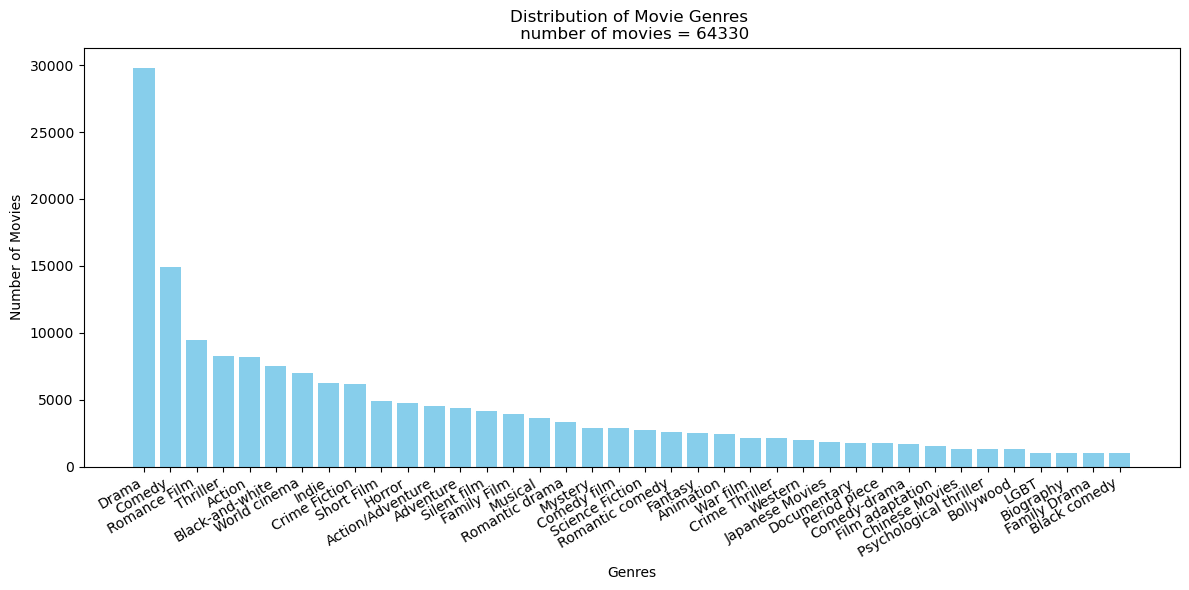

In [44]:
from collections import Counter
all_genres = [genre for sublist in metadata_CMU['Movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)
genre_counts = {genre: count for genre, count in genre_counts.items() if count >= 1000}
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(genre_counts.keys(), genre_counts.values(), color='skyblue')
plt.title(f'Distribution of Movie Genres \n number of movies = {len(metadata_CMU)}')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

<h3>Analysis of ratio evolution with some specific countries</h3>

We check the distribution of the movies which are unique for each country

In [53]:
all_countries = set(country for sublist in merged_df["Movie_countries"] for country in sublist)
country_dict = {}
for country in all_countries:
    country_dict[country] = metadata[metadata["Movie_countries"].apply(lambda x: country in x and len(x) == 1)].shape[0]
# country_dict
sorted_by_values = dict(sorted(country_dict.items(), key=lambda item: item[1], reverse=True))
sorted_by_values

{'United States of America': 30300,
 'India': 8241,
 'United Kingdom': 5389,
 'Japan': 2242,
 'France': 1853,
 'Italy': 1730,
 'Canada': 1342,
 'Germany': 1288,
 'Argentina': 1266,
 'China': 1157,
 'South Korea': 797,
 'Mexico': 685,
 'Australia': 631,
 'Netherlands': 606,
 'Russia': 557,
 'Spain': 477,
 'Denmark': 418,
 'Sweden': 415,
 'Philippines': 344,
 'Czechia': 297,
 'Poland': 284,
 'Norway': 228,
 'Serbia': 223,
 'Hungary': 221,
 'Brazil': 214,
 'Thailand': 170,
 'Turkey': 165,
 'Iran': 163,
 'Pakistan': 162,
 'Finland': 158,
 'Greece': 135,
 'Israel': 132,
 'Egypt': 124,
 'Czech Republic': 111,
 'Indonesia': 108,
 'Croatia': 106,
 'Austria': 102,
 'South Africa': 91,
 'New Zealand': 86,
 'Malaysia': 85,
 'Sri Lanka': 82,
 'Ireland': 79,
 'Portugal': 75,
 'Belgium': 73,
 'Cambodia': 65,
 'Romania': 65,
 'Bulgaria': 63,
 'Bangladesh': 59,
 'Singapore': 57,
 'Taiwan': 50,
 'Switzerland': 45,
 'Iceland': 36,
 'Nepal': 34,
 'Colombia': 26,
 'Cuba': 25,
 'Estonia': 25,
 'Chile': 23,

We plot distribution of some of the most impactful countres for movie industry

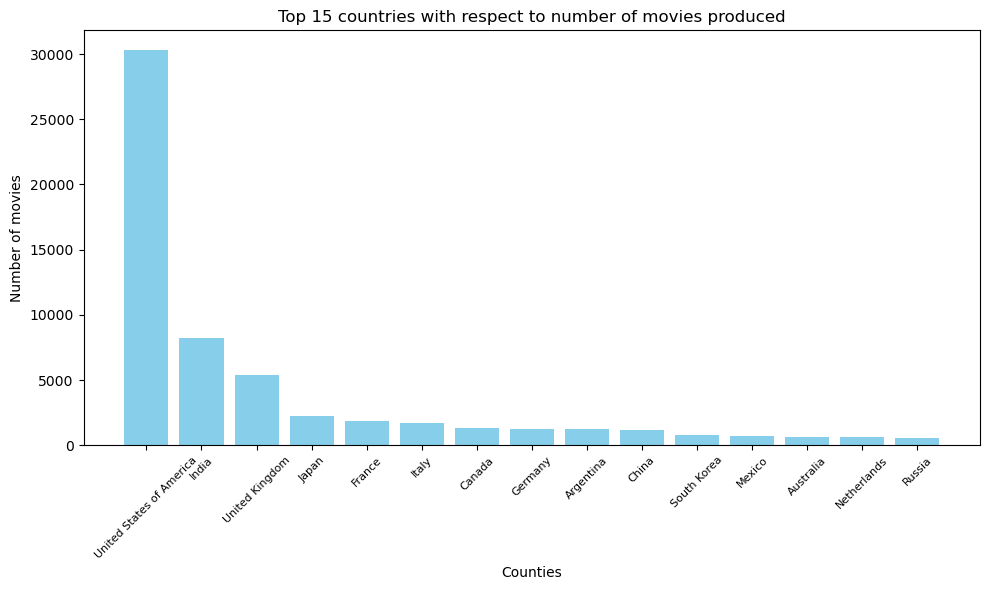

In [54]:
plt.figure(figsize=(10, 6))
plt.bar(list(sorted_by_values.keys())[:15], list(sorted_by_values.values())[:15], color='skyblue')

plt.title("Top 15 countries with respect to number of movies produced")
plt.xlabel("Counties")
plt.ylabel("Number of movies")

plt.xticks(rotation=45, fontsize=8)

plt.tight_layout()
plt.show()

We plot female ratio for 12 countries with most of the movies

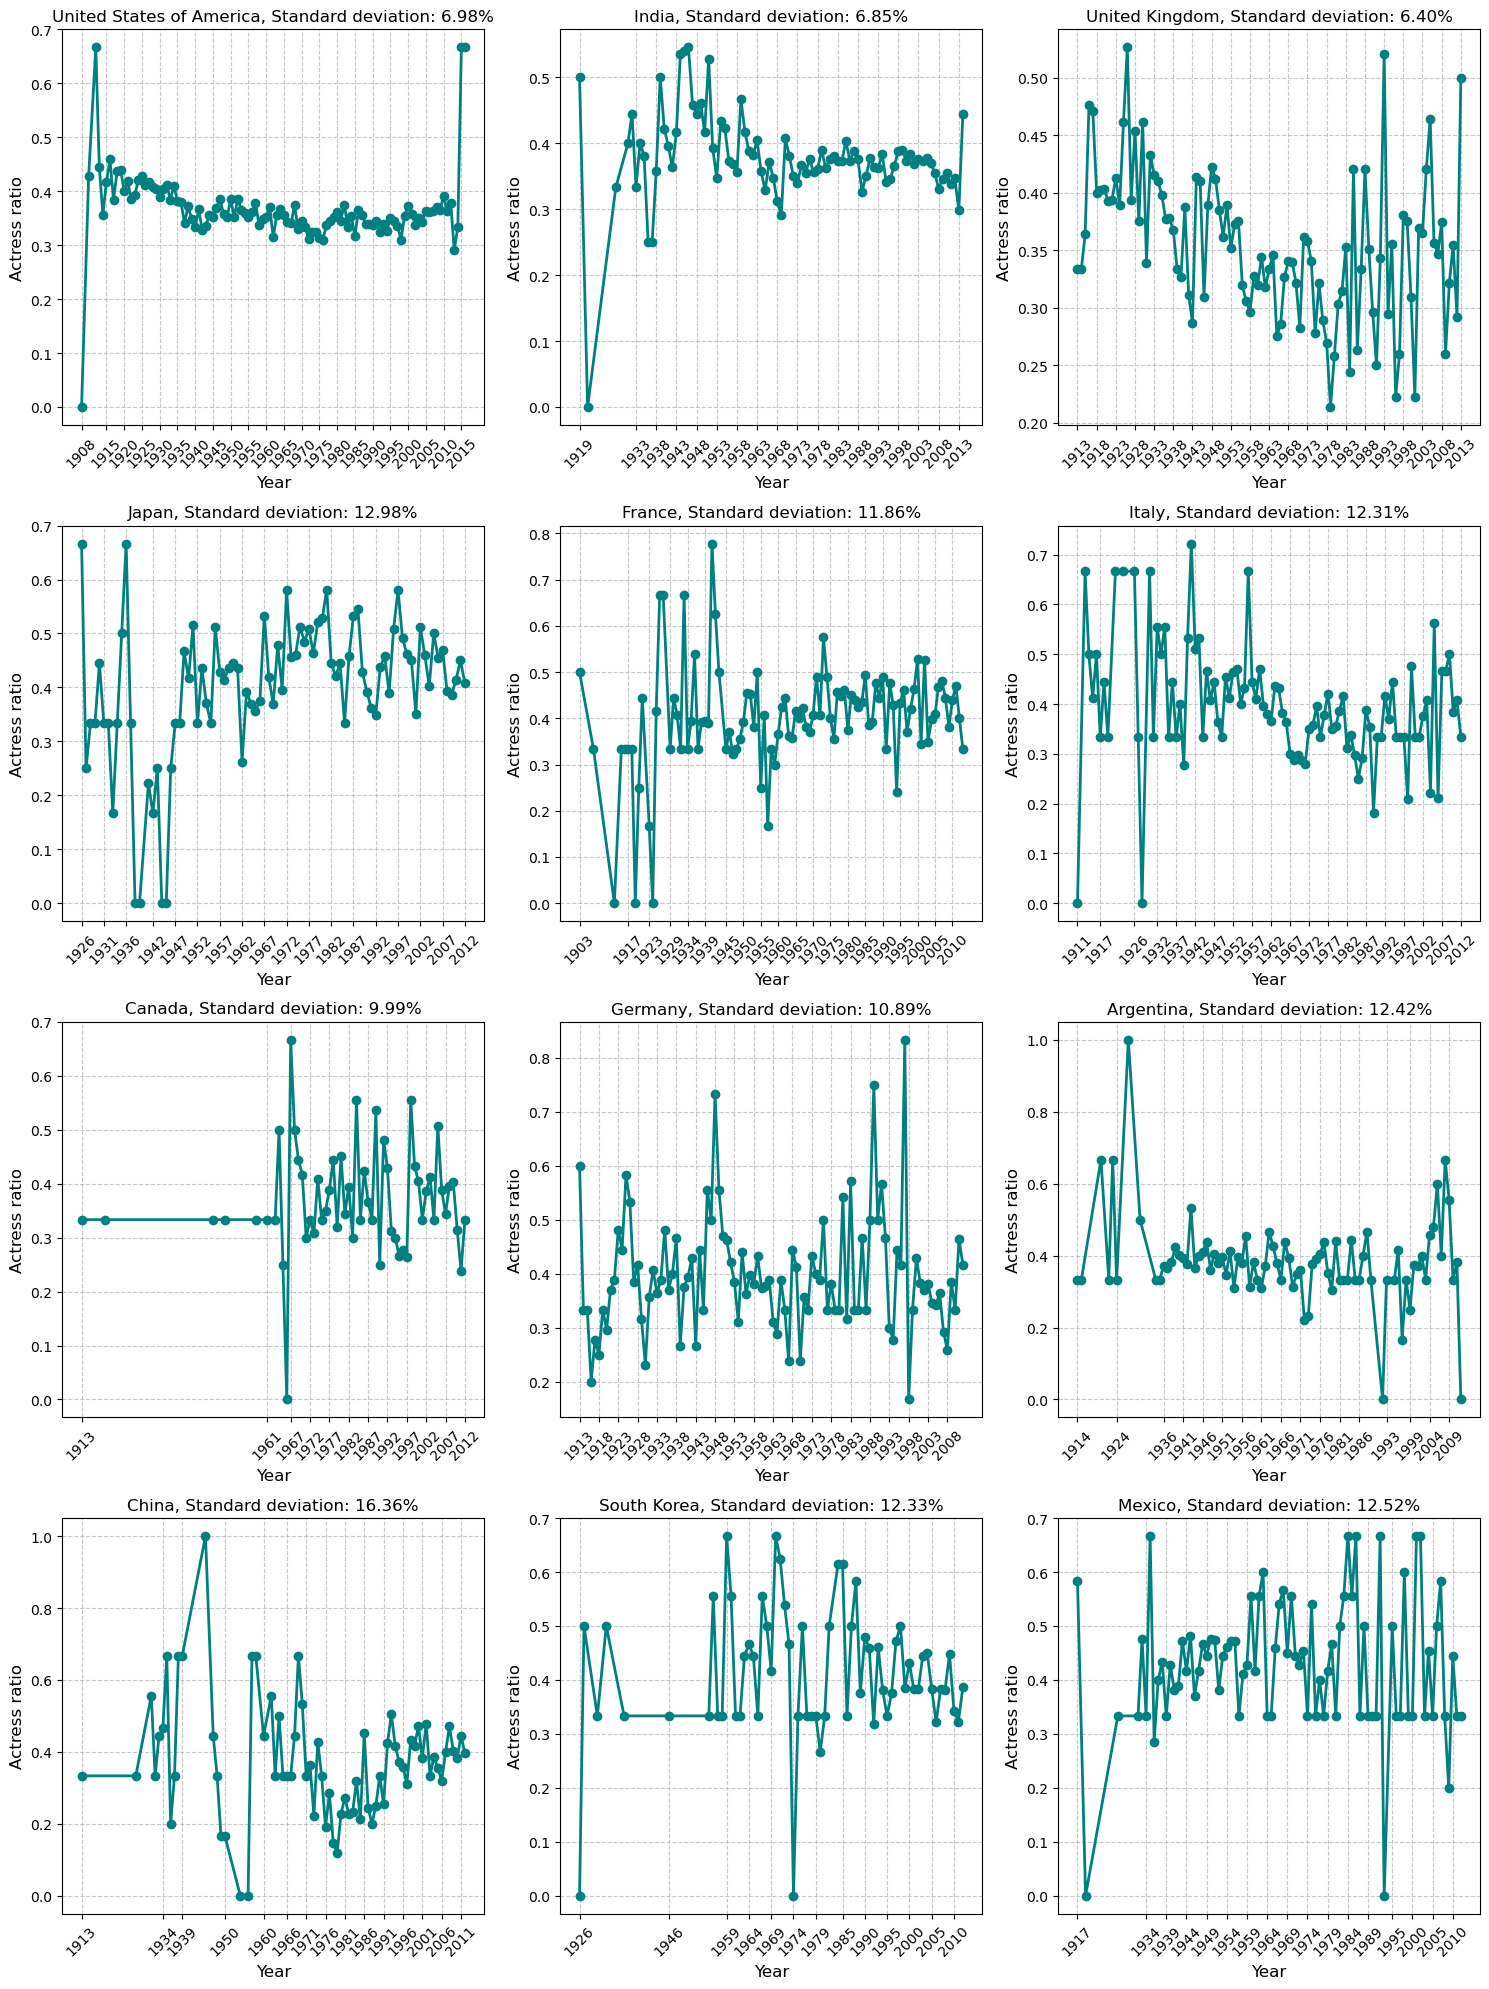

In [55]:
num_countries = 12
countries = list(sorted_by_values.keys())[:num_countries]
cols = 3  
rows = (num_countries // cols) + (num_countries % cols > 0)  

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  
for i, country in enumerate(countries):
    plt.sca(axes[i]) 
    std = country_female_ratio(copy_merged_df, country) 
    axes[i].set_title(f"{country}, Standard deviation: {std*100:.2f}%")  

plt.tight_layout()
plt.show()

We see that most of the countries have less actress than actors in the film cast. However, some countires like Japan or Mexico have higher actress ratio. 

These graphs could be improved for milestone 3: we could do analysis of continents/regions of the world, we could look not for single years, but for example decades/5 years periods

We now look at ratio evolution between film genre which are highly non-inclusive (films where women are highly not included (like war films) or where they are more present like erotic films)

How to read this graph : in 1940, when the cast in more than 70% man, then there is 85% of first role which are man

We see that when the cast is mostly composed of man, the first role is mainly attributed to male actors. 

## Transforming the dataframe for further analysis (merging and more)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json 
from collections import Counter
import re
import ast


movie_data_unmerged = pd.read_table(CMU_PATH + "movie.metadata.tsv", header=None)

movie_data_unmerged.columns = [
    "Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", 
    "Movie_countries",  
    "Movie_genres"     
]

with open(CMU_PATH + "plot_summaries.txt", "r", encoding="utf-8") as f:
    file = f.readlines()

data = [line.strip().split("\t", 1) for line in file]

summaries_df = pd.DataFrame(data, columns=["Wikipedia_movie_ID", "Movie_Summary"])

summaries_df['Wikipedia_movie_ID'] = summaries_df['Wikipedia_movie_ID'].apply(int)

df_character = pd.read_table(CMU_PATH+"character.metadata.tsv", header=None)

df_character.columns = ["Wikipedia_movie_ID",
"Freebase_movie_ID",
"Movie_release_date",
"Character_name",
"Actor_date_of_birth",
"Actor_gender",
"Actor_height", #in meters
"Actor_ethnicity",
"Actor_name",
"Actor_age_at_movie_release",
"Freebase_character/actor_map_ID",
"Freebase_character_ID",
"Freebase_actor_ID"]

df_character["Wikipedia_movie_ID"] = df_character["Wikipedia_movie_ID"].apply(int)
#here we only keep the year (and not the month) + we put the same format
df_character["Movie_release_date"] = df_character["Movie_release_date"].apply(lambda x: int(str(x).split("-")[0]) if type(x) == str else np.nan)

df_movie = movie_data_unmerged.merge(summaries_df, on="Wikipedia_movie_ID", how='inner')

df_movie["Movie_genres"] = df_movie["Movie_genres"].apply(lambda x: list(json.loads(x).values()))
#some movies have release date in the form year-month-day, we only want the year, and some have nan values
df_movie["Movie_release_date"] = df_movie["Movie_release_date"].apply(lambda x: int(str(x).split("-")[0]) if type(x) == str else np.nan)
df_movie.loc[df_movie["Movie_name"] == "Hunting Season", "Movie_release_date"] = 2010

def find_movie_ID(movie_name):
    return int(df_movie[df_movie["Movie_name"] == movie_name]["Wikipedia_movie_ID"].values[0])

df_imdb = pd.read_csv('merged_imdb_2.csv')
df_imdb.head()
df_imdb["actors"] = df_imdb["actors"].apply(lambda x: ast.literal_eval(x))

df_imdb.rename(columns={"Wikipedia movie ID": "Wikipedia_movie_ID"}, inplace=True)

df_actor = pd.DataFrame()
df_actor["actor"] = [item for sublist in df_imdb['actors'].tolist() for item in sublist]
df_actor = df_actor.drop_duplicates()

In [28]:
df_movie = df_movie.merge(df_imdb[["gender", "Wikipedia_movie_ID"]], on="Wikipedia_movie_ID", how='inner')

In [29]:
df_movie["Movie_countries"] = df_movie["Movie_countries"].apply(lambda x: list(json.loads(x).values()))

### Basic preliminary gender analyis

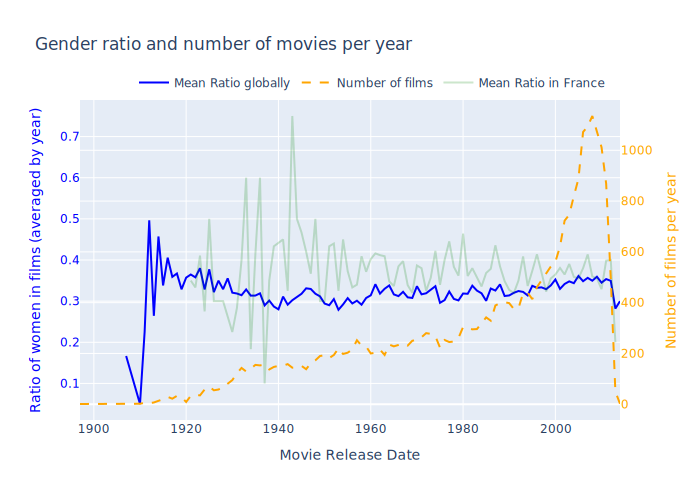

In [30]:
# here we analyse the ratio of actors/actresses by movie

df_movie["W"] = df_movie["gender"].apply(lambda x: Counter(x)["F"])
df_movie["M"] = df_movie["gender"].apply(lambda x: Counter(x)["M"])
df_movie["Ratio"] = df_movie.apply(lambda x: x["W"]/(x["W"] + x["M"]) if x["W"] + x["M"] != 0 else np.nan, axis=1)


import plotly.graph_objects as go

mean_ratio = df_movie.groupby("Movie_release_date")["Ratio"].mean()
count = df_movie.groupby("Movie_release_date").size()

mean_ratio_france = df_movie[df_movie["Movie_countries"].apply(lambda x: "France" in x)].groupby("Movie_release_date")["Ratio"].mean()

fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=mean_ratio.index,
        y=mean_ratio,
        name="Mean Ratio globally",
        mode="lines",
        line=dict(color="blue"),
    )
)


fig.add_trace(
    go.Scatter(
        x=count.index,
        y=count,
        name="Number of films",
        mode="lines",
        line=dict(color="orange", dash="dash"),
        yaxis="y2",  
    )
)

fig.add_trace(
    go.Scatter(
        x=mean_ratio_france.index,
        y=mean_ratio_france,
        name="Mean Ratio in France",
        mode="lines",
        opacity=0.2,
        line=dict(color="green"),
    )
)


fig.update_layout(
    title="Gender ratio and number of movies per year",
    xaxis=dict(title="Movie Release Date"),
    yaxis=dict(title="Ratio of women in films (averaged by year)", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
    yaxis2=dict(
        title="Number of films per year",
        titlefont=dict(color="orange"),
        tickfont=dict(color="orange"),
        overlaying="y",
        side="right",
    ),
    legend=dict(x=0.1, y=1.1, orientation="h"),
)


fig.show("svg")

#to html file
#fig.write_html("Mean_Ratio_and_Count_by_Movie_Release_Date.html")

In [5]:
#finding all movie genres

all_genres = [genre for sublist in df_movie['Movie_genres'] for genre in sublist]
all_genres = list(set(all_genres))
genre_dict = {}
for genre in all_genres:
    a = float(df_movie[df_movie['Movie_genres'].apply(lambda x: genre in x)]['Ratio'].mean())
    if not np.isnan(a):
        genre_dict[genre] = [a, df_movie[df_movie['Movie_genres'].apply(lambda x: genre in x)].shape[0]]
    

In [6]:
genres_ratio = dict(sorted(genre_dict.items(), key=lambda item: item[1][0], reverse=True))

In [7]:
#keeping only the genres with more than 13 films
genres_ratio = {k: [v[0],v[1]] for k, v in genres_ratio.items() if v[1] > 13}

In [8]:
values = [v[0] for v in genres_ratio.values()]
movies_count = [v[1] for v in genres_ratio.values()]

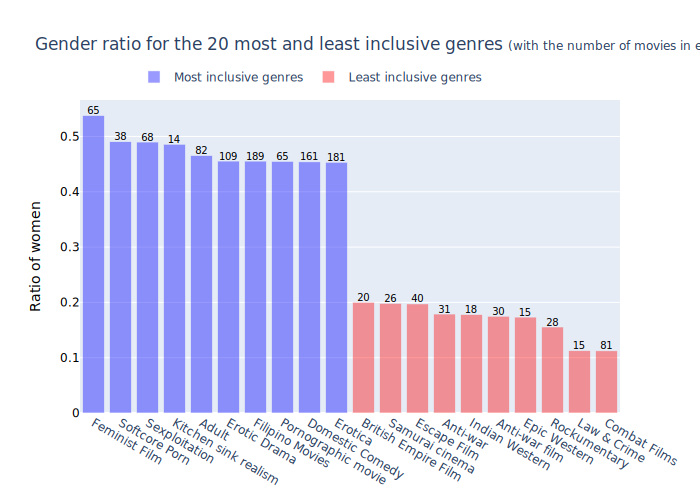

In [9]:
#analysing the inclusivness of each genre

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=list(genres_ratio.keys())[:10],
        y=values[:10],
        marker_color="blue",
        opacity=0.4,
        name="Most inclusive genres",
    )
)

fig.add_trace(
    go.Bar(
        x=list(genres_ratio.keys())[len(values)-10:],
        y=values[len(values)-10:],
        marker_color="red",
        opacity=0.4,
        name="Least inclusive genres",
    )
)

fig.update_layout(
    title="Gender ratio for the 20 most and least inclusive genres <span style='font-size: 12px;'>(with the number of movies in each genre)</span>",
    yaxis=dict(title="Ratio of women", titlefont=dict(color="black"), tickfont=dict(color="black")),
    legend=dict(x=0.1, y=1.12, orientation="h"),
)


for i, genre in enumerate(list(genres_ratio.keys())[:10]):
    fig.add_annotation(
        x=genre,
        y=values[i]+0.01,
        text=str(movies_count[i]),
        showarrow=False,
        font=dict(color="black", size=10)
    )
for i, genre in enumerate(list(genres_ratio.keys())[len(values)-10:]):
    fig.add_annotation(
        x=genre,
        y=values[len(values)-10:][i]+0.01,
        text=str(movies_count[len(values)-10:][i]),
        showarrow=False,
        font=dict(color="black", size=10)
    )
fig.show("svg")
#fig.write_html("top_genres.html")

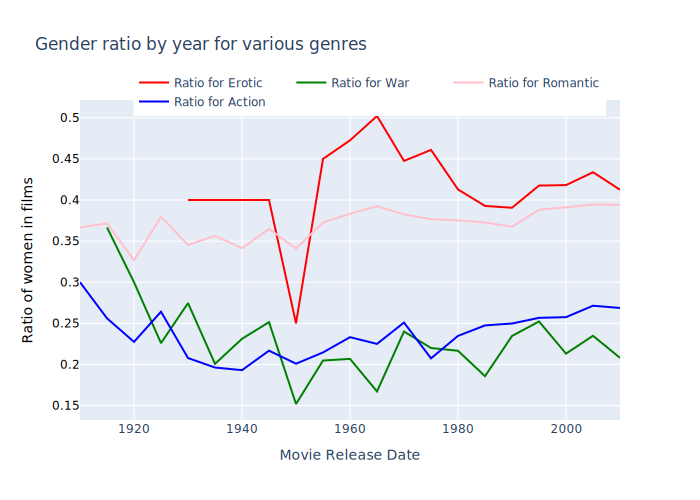

In [10]:
# NOT SHOWN ON WEBSITE

#This section was made to analyse the genre evolution. 



import plotly.graph_objects as go

genres = ["Drama", "Erotic", "Thriller"]

erotic_genres = ['Sex comedy','Erotica','Erotic thriller','Pornographic movie','Adult','Erotic Drama','Sexploitation','Softcore Porn','Gay pornography','Hardcore pornography','Pornography']
war_genres = ["War film"]
romantic_genres = ["Romantic drama", "Romantic comedy", "Romance Film"]
action_genres = ["Action", "Action/Adventure", "Adventure"]
dc = 5 #average over dc years
mean_romantic_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in romantic_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()
mean_erotic_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in erotic_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()
mean_war_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in war_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()
mean_action_ratio = df_movie[df_movie["Movie_genres"].apply(lambda x: any(movie_genre in x for movie_genre in action_genres))].groupby(df_movie["Movie_release_date"] // dc * dc)["Ratio"].mean()



genre_type = [mean_erotic_ratio, mean_war_ratio, mean_romantic_ratio, mean_action_ratio]
genre_name = ["Erotic", "War", "Romantic", "Action"]

colors = ["red", "green", "pink", "blue"]

fig = go.Figure()

for genre in genre_type:
    fig.add_trace(
        go.Scatter(
            x=genre.index,
            y=genre,
            name=f"Ratio for {genre_name.pop(0)}",
            mode="lines",
            line=dict(color=colors.pop(0)),
        )
    )



fig.update_layout(
    title="Gender ratio by year for various genres",
    xaxis=dict(title="Movie Release Date"),
    yaxis=dict(title="Ratio of women in films", titlefont=dict(color="black"), tickfont=dict(color="black")),
    yaxis2=dict(
        title="Number of films per year for various genres",
        titlefont=dict(color="orange"),
        tickfont=dict(color="orange"),
        overlaying="y",
        side="right",
    ),
    legend=dict(x=0.1, y=1.1, orientation="h"),
)


fig.show("svg")

#to html file
#fig.write_html(data_folder + "ratio_evolution_by_genre.html")

## Looking at actors individually

In [11]:
df_chara_small = df_character.copy()
df_chara_small = df_chara_small.drop(["Freebase_movie_ID", "Character_name", "Actor_height", "Freebase_character_ID",
                                      "Freebase_character/actor_map_ID", "Freebase_actor_ID", "Actor_ethnicity"], axis=1)

In [12]:
df_chara_small = df_chara_small.groupby("Actor_name").agg(lambda x: x.tolist()).reset_index()

In [14]:
df_chara_small["Actor_gender"] = df_chara_small["Actor_gender"].apply(np.unique).apply(lambda x: x[0])
df_chara_small["Actor_date_of_birth"] = df_chara_small["Actor_date_of_birth"].apply(np.unique).apply(lambda x: x[0])
df_chara_small = df_chara_small[df_chara_small["Actor_gender"].isin(["M", "F"])]
df_chara_small.head(5)

,Actor_name,Wikipedia_movie_ID,Movie_release_date,Actor_date_of_birth,Actor_gender,Actor_age_at_movie_release
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926.0, 1922.0]",1883-12-20,F,"[nan, nan]"
1,Daniel Newman,[20116200],[1998.0],1976-05-12,M,[22.0]
2,'Big Bill' Giddinger,[15056534],[1911.0],NaN,M,[nan]
3,'Big' Lee,[23010798],[1973.0],NaN,M,[nan]
5,'Crazy George' Henderson,[10050502],[1975.0],NaN,M,[nan]


In [15]:
#some date of birth were not correct
#these actors specifically because they made a lot of movies. It will be useful later 
df_chara_small.loc[df_chara_small["Actor_name"] == "Harrison Ford", "Actor_date_of_birth"] = 1942
df_chara_small.loc[df_chara_small["Actor_name"] == "Edward Burns", "Actor_date_of_birth"] = 1968 
df_chara_small.loc[df_chara_small["Actor_name"] == "Don Wilson", "Actor_date_of_birth"] = 1954

In [16]:
#the starting career is defined as the year of firt movie release
df_chara_small["Starting_career"] = df_chara_small["Movie_release_date"].apply(min)

In [18]:
#here we fetch the first roles from imdb to merge to the df_chara_small

first_role_df = df_imdb[["first_role_actor", "Movie_release_date_x"]].groupby("first_role_actor").agg(lambda x: x.tolist()).reset_index()
first_role_df = first_role_df.rename(columns={"first_role_actor": "Actor_name", "Movie_release_date_x": "Movie_release_date_1st_role"})
first_role_df.head(5)

,Actor_name,Movie_release_date_1st_role
0,'University' Jeevan,"[2007, 2006, 2008]"
1,'Weird Al' Yankovic,[1989]
2,2Mex,[2008]
3,50 Cent,"[2011, 2012, 2011, 2005]"
4,A. Michael Baldwin,"[2008, 1998, 1979]"


In [19]:
df_chara_small = df_chara_small.merge(first_role_df, on="Actor_name", how="outer")
df_chara_small.head(5)

,Actor_name,Wikipedia_movie_ID,Movie_release_date,Actor_date_of_birth,Actor_gender,Actor_age_at_movie_release,Starting_career,Movie_release_date_1st_role
0,Cesarine Prinz\t,"[22643470, 22643388]","[1926.0, 1922.0]",1883-12-20,F,"[nan, nan]",1922.0,NaN
1,Daniel Newman,[20116200],[1998.0],1976-05-12,M,[22.0],1998.0,NaN
2,'Big Bill' Giddinger,[15056534],[1911.0],NaN,M,[nan],1911.0,NaN
3,'Big' Lee,[23010798],[1973.0],NaN,M,[nan],1973.0,NaN
4,'Crazy George' Henderson,[10050502],[1975.0],NaN,M,[nan],1975.0,NaN


In [20]:
#computing how many years it took the actor to get 1st role. 
import math
def years_to_first(x, start):
    if type(x) == list:
        return min(x) - start
    else:
        return np.nan

In [21]:
df_chara_small["Years_to_1st"] = df_chara_small.apply(lambda x: years_to_first(x["Movie_release_date_1st_role"], x["Starting_career"]), axis=1)

In [22]:
#number of actors that have and do not have first role (ever)
len(df_chara_small)

101877

In [23]:
#selecting actors that have or had first role in their career 
df_chara_small = df_chara_small[(df_chara_small["Years_to_1st"].isnull()) | (df_chara_small["Years_to_1st"] > 0)]

In [24]:
#remaing actors from the dataframe
len(df_chara_small)

96416

In [25]:
def find_movie_genres(films_id):
    if type(films_id) != list:
        return np.nan
    else:
        return df_movie[df_movie["Wikipedia_movie_ID"].isin(films_id)]["Movie_genres"].apply(lambda x: list(x)).sum()


In [26]:
df_chara_small["Movie_genres"] = df_chara_small["Wikipedia_movie_ID"].apply(find_movie_genres)

In [32]:
df_chara_small.groupby("Actor_gender")["Years_to_1st"].mean()

Actor_gender
F    7.837449
M    9.169874
Name: Years_to_1st, dtype: float64

In [33]:
role_dict = df_imdb["first_role_gender"].value_counts().to_dict()
print(f'The number of woman actress as first role is {role_dict["F"]}, while the actors represent {role_dict["M"]}')
print("")
print(f"Thus the ratio actors/actress is {role_dict['M']/(role_dict['F']+role_dict['M'])}")

The number of woman actress as first role is 13647, while the actors represent 35196

Thus the ratio actors/actress is 0.7205945580738284


In [34]:
#here we add colomns to imdb dataframe for gender type in binary form 
def role_man(first_role):
    return 1 if first_role == "M" else 0
role = ["first", "second", "third"]
for el in role:
    df_imdb["Binary_"+el] = df_imdb[f"{el}_role_gender"].apply(lambda x: role_man(x))

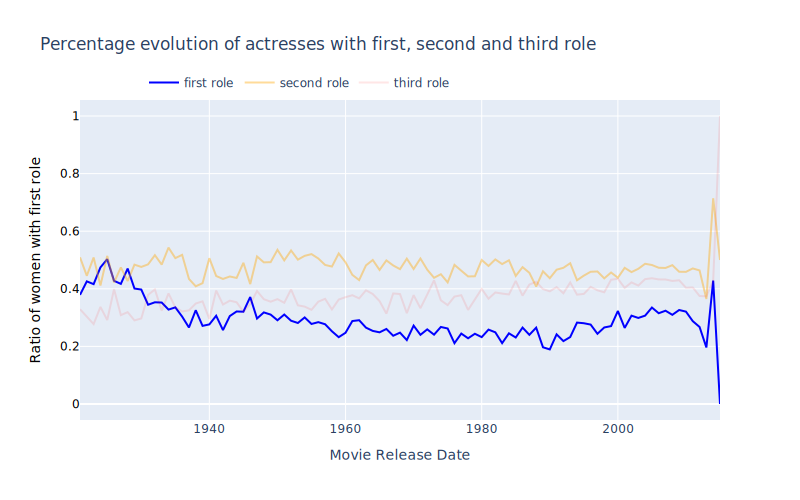

In [35]:
fig = go.Figure()

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
)
colors = ["blue", "orange", "red"]
op =[1, 0.4, 0.1]

for el in role:
    num_m = df_imdb[df_imdb["Movie_release_date_x"] >1920].groupby("Movie_release_date_x")[f"Binary_{el}"].sum()
    num_w = df_imdb[df_imdb["Movie_release_date_x"] >1920].groupby("Movie_release_date_x")[f"Binary_{el}"].count() - num_m

    fig.add_trace(
        go.Scatter(
            x=num_m.index,
            y=num_w/(num_m+num_w),
            name=f"{el} role",
            mode="lines",
            line=dict(color=colors.pop(0)),
            opacity=op.pop(0)
        )
    )


fig.update_layout(
    title="Percentage evolution of actresses with first, second and third role",
    xaxis=dict(title="Movie Release Date"),
    yaxis=dict(title="Ratio of women with first role", titlefont=dict(color="black"), tickfont=dict(color="black")),
    legend=dict(x=0.1, y=1.1, orientation="h"),
)
fig.show("svg")

#fig.write_html(data_folder + "percentage_evolution_of_actresses.html")

In [36]:
#finding the gender ratio for first role
genre_dict_first = {}
all_genres = list(set(all_genres))
for genre in all_genres:
    dictt = df_imdb[df_imdb["Movie_genres"].apply(lambda x: genre in x)]["Binary_first"].value_counts().to_dict()
    if len(dictt) == 2:
        m = dictt[1]
        w = dictt[0]
    genre_dict_first[genre] = [m, w, w/(m+w)]


In [37]:
genre_dict_first = dict(sorted(genre_dict_first.items(), key=lambda item: item[1][2], reverse=True))
genre_dict_first = {k: v for k, v in genre_dict_first.items() if v[0] + v[1] > 20}

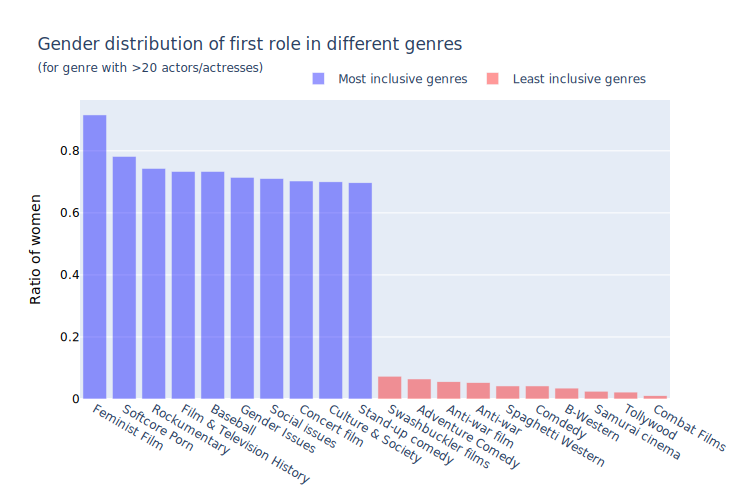

In [38]:
values = [v[2] for v in genre_dict_first.values()]
fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=750,
    height=500,
)
fig.add_trace(
    go.Bar(
        x=list(genre_dict_first.keys())[:10],
        y=values[:10],
        marker_color="blue",
        opacity=0.4,
        name="Most inclusive genres",
    )
)

fig.add_trace(
    go.Bar(
        x=list(genre_dict_first.keys())[len(values)-10:],
        y=values[len(values)-10:],
        marker_color="red",
        opacity=0.4,
        name="Least inclusive genres",
    )
)

fig.update_layout(
    title="Gender distribution of first role in different genres <br><span style='font-size: 12px;'>(for genre with >20 actors/actresses)</span>",
    yaxis=dict(title="Ratio of women", titlefont=dict(color="black"), tickfont=dict(color="black")),
    legend=dict(x=0.37, y=1.12, orientation="h", bgcolor="rgba(0,0,0,0)"),
)

fig.show("svg")
fig.write_html("first_role_genre.html")

In [39]:
erotic_genres = ['Sex comedy','Erotica','Erotic thriller','Pornographic movie','Adult','Erotic Drama','Sexploitation','Softcore Porn','Gay pornography','Hardcore pornography','Pornography']
war_genres = ["War film"]
religious_genres = ["Religious Film"]
romantic_genres = ["Romantic drama", "Romantic comedy, Romance Film"]

In [40]:
#here is an analysis of the number of years to 1st role by movie genre
print('erotic')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in erotic_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')
print('war')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in war_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')
print('religious')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in religious_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')
print('romantic')
print(df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: any(i in x for i in romantic_genres) if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean())
print('')

erotic
Actor_gender
F    8.138528
M    9.299870
Name: Years_to_1st, dtype: float64

war
Actor_gender
F    8.434866
M    9.509904
Name: Years_to_1st, dtype: float64

religious
Actor_gender
F    8.750000
M    9.459459
Name: Years_to_1st, dtype: float64

romantic
Actor_gender
F    8.473399
M    9.291090
Name: Years_to_1st, dtype: float64



In [41]:
all_genres = [genre for sublist in df_movie['Movie_genres'] for genre in sublist]
genre_counts = Counter(all_genres)

In [42]:
#analysing the ratio of number of years to 1st role between gender for all the genre 
def ratio_years_to_first(movie_genre):
    manwoman = df_chara_small[df_chara_small["Movie_genres"].apply(lambda x: movie_genre in x if type(x) == list else False)].groupby("Actor_gender")["Years_to_1st"].mean()
    if len(manwoman) != 2 or math.isnan(manwoman["M"]):
        return np.nan
    else:
        return manwoman["M"]/manwoman["F"]
    
genres = list(set([item for sublist in df_movie["Movie_genres"].tolist() for item in sublist]))

dict_genres = {}
for genre in genres:
    dict_genres[genre] = [ratio_years_to_first(genre), genre_counts[genre]/(sum(genre_counts.values()))]

In [43]:
dict(sorted(dict_genres.items(), key=lambda item: item[1][1], reverse=True))

weighted_ratio = {}
for key in dict_genres.keys():
    weighted_ratio[key] = dict_genres[key][0] * dict_genres[key][1]
np.nansum(list(weighted_ratio.values()))

1.1458116609553501

In [44]:
#shows on average the number of films with first role per gender
df_chara_small["Number_movies_1st"] = df_chara_small["Movie_release_date_1st_role"].apply(lambda x: len(x) if type(x) == list else np.nan)
df_chara_small.groupby("Actor_gender")["Number_movies_1st"].mean()

Actor_gender
F    2.673256
M    3.439831
Name: Number_movies_1st, dtype: float64

In [45]:
#checking with famous actresses. She has 9 films as first role
df_chara_small[df_chara_small["Actor_name"] == "Scarlett Johansson"]

,Actor_name,Wikipedia_movie_ID,Movie_release_date,Actor_date_of_birth,Actor_gender,Actor_age_at_movie_release,Starting_career,Movie_release_date_1st_role,Years_to_1st,Movie_genres,Number_movies_1st
85720,Scarlett Johansson,"[22144721, 22144721, 11723307, 1599839, 595971...","[2010.0, 2010.0, 1999.0, 2004.0, 2003.0, 2001....",1984-11-22,F,"[25.0, 25.0, 14.0, 20.0, 18.0, 16.0, 11.0, 21....",1994.0,"[1999, 2007, 2003, 1996, 2005, 2004, 2006, 200...",2.0,"[Costume drama, History, Period piece, Drama, ...",9.0


In [46]:
#doing some analysis between the most famous actors/actresses. To see how they compare. 
famous_actress = ["Scarlett Johansson", "Jennifer Lawrence", "Angelina Jolie", "Meryl Streep", "Julia Roberts", "Cate Blanchett", "Nicole Kidman", "Charlize Theron", "Natalie Portman", "Emma Stone", "Anne Hathaway", "Sandra Bullock"] #"Reese Witherspoon", "Jessica Chastain", "Keira Knightley", "Kate Winslet", "Amy Adams", "Halle Berry", "Diane Keaton", "Julianne Moore", "Maggie Smith"]
print(len(famous_actress))
famous_actors = ["Tom Cruise", "Brad Pitt", "Johnny Depp", "Leonardo DiCaprio", "Will Smith", "Robert Downey Jr.", "Dwayne Johnson", "Tom Hanks", "George Clooney", "Daniel Craig", "Chris Hemsworth", "Chris Evans", "Chris Pratt"]
print(len(famous_actors))
print(f'Average number of films as 1st role for world main actress {df_chara_small[df_chara_small["Actor_name"].isin(famous_actress)]["Number_movies_1st"].mean()}')
print(f'Average number of films as 1st role for world main actors {df_chara_small[df_chara_small["Actor_name"].isin(famous_actors)]["Number_movies_1st"].mean()}')

12
13
Average number of films as 1st role for world main actress 10.666666666666666
Average number of films as 1st role for world main actors 18.333333333333332


In [47]:
#mean age of actor/actresse for first firlm
df_chara_small["Actor_age_at_movie_release"].apply(lambda x: min(x) if type(x) == list else np.nan).mean()

30.719829699968795

### Looking at the age of the actors

In [48]:
#now we look at the starting and ending age of all actors/actresses
career_age = {}
df_chara_small["Age_1st_role"] = df_chara_small["Actor_age_at_movie_release"].apply(lambda x: min(x) if type(x) == list else np.nan)
career_age["Start"] = df_chara_small.groupby('Actor_gender')["Age_1st_role"].mean().to_dict()
career_age

{'Start': {'F': 27.075574577861165, 'M': 32.95518952744012}}

Look at age of last movie between age. To see variance 
make a plot of all ratio of years to 1st role in movie for all genres 


In [49]:
df_chara_small["Last_movie_age"] = df_chara_small["Actor_age_at_movie_release"].apply(lambda x: max(x) if type(x) == list else np.nan)
career_age["End"] = df_chara_small.groupby('Actor_gender')["Last_movie_age"].mean().to_dict()

career_age

{'Start': {'F': 27.075574577861165, 'M': 32.95518952744012},
 'End': {'F': 35.49888602251407, 'M': 42.415270085593036}}

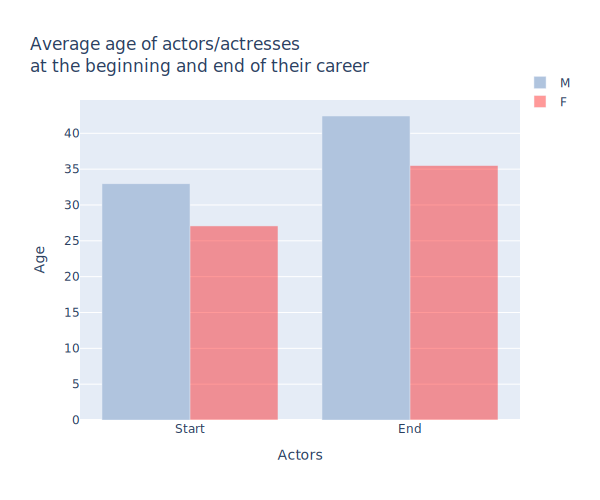

In [60]:

fig = go.Figure()

fig.update_layout(
    autosize=True,
    width=600,
    height=500,
)
fig.add_trace(go.Bar(
    x=['Start', 'End'],
    y=[career_age["Start"]["M"], career_age["End"]["M"]],
    name='M',
    marker_color='lightsteelblue'
))
fig.add_trace(go.Bar(
    x=['Start', 'End'],
    y=[career_age["Start"]["F"], career_age["End"]["F"]],
    name='F',
    marker_color='red',
    opacity=0.4
))
fig.update_layout(
    title="Average age of actors/actresses <br>at the beginning and end of their career",
    xaxis=dict(title="Actors"),
    yaxis=dict(title="Age"),
    legend=dict(x=1, y=1.1, orientation="v"),
)
fig.show("svg")

fig.write_html("average_age_of_actors.html")

In [51]:
#same analysis but looking at top movies
top_movies = df_movie.sort_values(by= "Movie_box_office_revenue", ascending=False).head(7217)["Wikipedia_movie_ID"]
#7217 films wiht revenue

In [52]:
#selecting all the actors that play in big movie
actors_top_movies = df_chara_small[df_chara_small.apply(lambda x: any(i in list(top_movies) for i in x["Wikipedia_movie_ID"]) if type(x["Wikipedia_movie_ID"])==list else False, axis=1)]

In [53]:
def find_movie_pos_and_age(movie_list):
    ##finds the position of the top movie in the movie list of the df
    dic_movie = {}
    for mov in movie_list:
        if mov in list(top_movies):
            dic_movie[mov] = movie_list.index(mov)
    
    return dic_movie

actors_top_movies["top_films"] = actors_top_movies["Wikipedia_movie_ID"].apply(lambda x: list(find_movie_pos_and_age(x).keys()))
actors_top_movies["index_of_top_film"] = actors_top_movies["Wikipedia_movie_ID"].apply(lambda x: list(find_movie_pos_and_age(x).values()))

/var/folders/4l/yz8mrkq91sl802y_wzywbvnc0000gn/T/ipykernel_73609/3971206100.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4l/yz8mrkq91sl802y_wzywbvnc0000gn/T/ipykernel_73609/3971206100.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
actors_top_movies["Age_at_top_film"] = actors_top_movies.apply(lambda x: [x["Actor_age_at_movie_release"][i] for i in x["index_of_top_film"]], axis=1)

/var/folders/4l/yz8mrkq91sl802y_wzywbvnc0000gn/T/ipykernel_73609/2701808925.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
age_top = actors_top_movies[["Actor_gender", "Age_at_top_film"]].explode("Age_at_top_film")

34.35287735635821
40.48450587230901


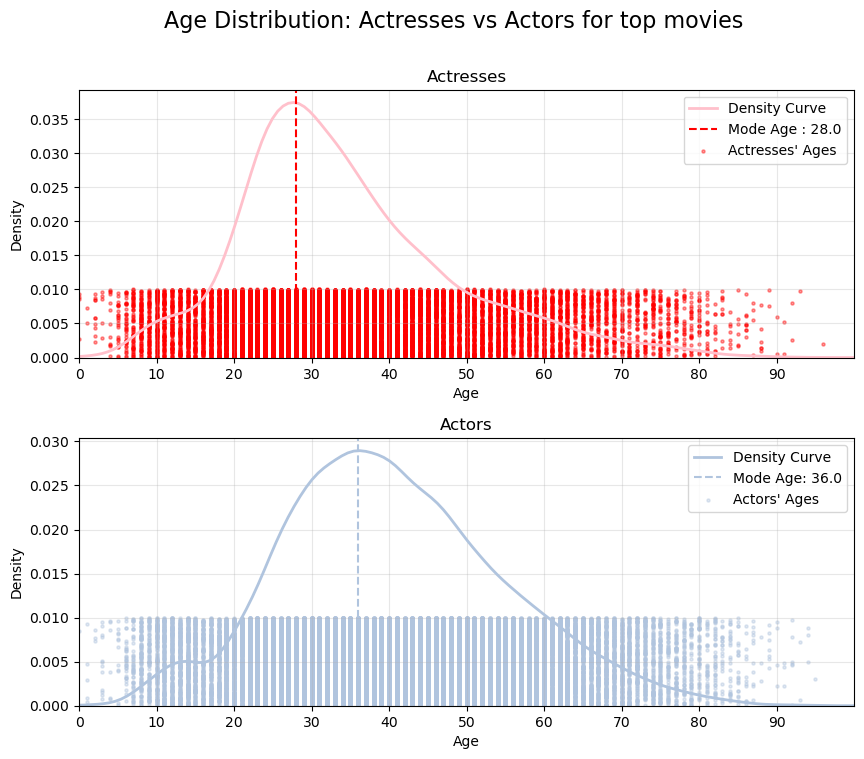

In [56]:
#gender analysis for top actors 
import seaborn as sns
import statistics as stats
ages_w = age_top[(age_top['Actor_gender'] == 'F') & (age_top['Age_at_top_film'].notna())]['Age_at_top_film']
ages_m = age_top[(age_top['Actor_gender'] == 'M') & (age_top['Age_at_top_film'].notna())]['Age_at_top_film']

print(ages_w.mean())
print(ages_m.mean())
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False, gridspec_kw={'hspace': 0.3})


sns.kdeplot(ages_w, ax=axes[0], color='pink', linewidth=2, label="Density Curve")

axes[0].axvline(stats.mode(ages_w), color='red', linestyle='--', label=f"Mode Age : {stats.mode(ages_w)}")
axes[0].scatter(
    ages_w, 
    np.random.uniform(0, 0.01, len(ages_w)), 
    color='red', 
    alpha=0.4, 
    s=5, 
    label="Actresses' Ages"
)
axes[0].set_xlim(0, 100)
axes[0].set_title("Actresses")
axes[0].set_xlabel("Age")
axes[0].set_xticks(np.arange(0, 100, 10))

axes[0].legend()
axes[0].grid(alpha=0.3)


sns.kdeplot(ages_m, ax=axes[1], color='lightsteelblue', linewidth=2, label="Density Curve")
axes[1].axvline(stats.mode(ages_m), color='lightsteelblue', linestyle='--', label=f"Mode Age: {stats.mode(ages_m)}")
axes[1].scatter(
    ages_m, 
    np.random.uniform(0, 0.01, len(ages_m)), 
    color='lightsteelblue', 
    alpha=0.4, 
    s=5, 
    label="Actors' Ages"
)

axes[1].set_title("Actors")
axes[1].set_xlabel("Age")
axes[1].set_xlim(0, 100)
axes[1].set_xticks(np.arange(0, 100, 10))

axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle("Age Distribution: Actresses vs Actors for top movies", fontsize=16)
plt.show("svg")


#fig.savefig("age_distribution.png")


### Looking at age distribution for first role

In [57]:
df_age_1st = df_chara_small[["Movie_release_date_1st_role", "Actor_name", "Actor_date_of_birth", 'Actor_gender', 'Wikipedia_movie_ID']].dropna()
df_age_1st["Actor_date_of_birth"] = df_age_1st["Actor_date_of_birth"].apply(lambda x: x[:4] if type(x)!= int else x)
df_age_1st = df_age_1st.explode("Movie_release_date_1st_role")
df_age_1st["Age_first_role"] = df_age_1st.apply(lambda x: int(x["Movie_release_date_1st_role"]) - int(x["Actor_date_of_birth"]), axis=1)



In [58]:
len(df_age_1st)

22560

In [1]:
import seaborn as sns
import statistics as stats
ages_w = df_age_1st[(df_age_1st['Actor_gender'] == 'F') & (df_age_1st["Movie_release_date_1st_role"] > 1900)]['Age_first_role']
ages_m = df_age_1st[(df_age_1st['Actor_gender'] == 'M') & (df_age_1st["Movie_release_date_1st_role"] > 1900)]['Age_first_role']

print("mean age women:", ages_w.mean())
print("mean age men:", ages_m.mean())
multm = stats.multimode(ages_m)
multw = stats.multimode(ages_w)
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=False, gridspec_kw={'hspace': 0.3})


sns.kdeplot(ages_w, ax=axes[0], color='lightcoral', linewidth=2, label="Density Curve")

axes[0].axvline(multw, color='lightcoral', linestyle='--', label=f"Mode Age : {multw}")
axes[0].scatter(
    ages_w, 
    np.random.uniform(0, 0.01, len(ages_w)), 
    color='lightcoral', 
    alpha=0.1, 
    s=5, 
    label="Actresses' Ages"
)

axes[0].set_title("Actresses")
axes[0].set_xlabel("Age")
axes[0].set_xlim(0, 100)
axes[0].set_xticks(np.arange(0, 100, 10))
axes[0].legend()
axes[0].grid(alpha=0.3)


sns.kdeplot(ages_m, ax=axes[1], color='lightsteelblue', linewidth=2, label="Density Curve")
axes[1].axvline(multm, color='lightsteelblue', linestyle='--', label=f"Mode Age: {multm}")
axes[1].scatter(
    ages_m, 
    np.random.uniform(0, 0.01, len(ages_m)), 
    color='lightsteelblue', 
    alpha=0.1, 
    s=5, 
    label="Actors' Ages"
)

axes[1].set_title("Actors")
axes[1].set_xlabel("Age")
axes[1].set_xlim(0, 100)
axes[1].set_xticks(np.arange(0, 100, 10))
axes[1].legend()
axes[1].grid(alpha=0.3)


plt.suptitle("Age Distribution: Actresses vs Actors for first role", fontsize=16)
plt.show("svg")

#fig.savefig("age_distribution_first_role.png")

NameError: name 'df_age_1st' is not defined

# Gender description analysis:

In [2]:
char_sum_CMU = df_movie
# Adding female percentage as column
char_sum_CMU['Female Percentage'] = char_sum_CMU['Actor gender'].apply(wu.calculate_female_percentage)
char_sum_CMU = char_sum_CMU[char_sum_CMU['Female Percentage'] != -1]
female_movies = char_sum_CMU[char_sum_CMU["Female Percentage"] >= 66].copy()
male_movies = char_sum_CMU[char_sum_CMU["Female Percentage"] <= 33].copy()
print('Number of movies with high female ratio: ', len(female_movies))
print('Number of movies with high male ratio: ', len(male_movies))

NameError: name 'df_movie' is not defined

## Plotting distribution of female percentage:

In [3]:
wu.plot_female_percentage_graph(char_sum_CMU)

NameError: name 'wu' is not defined

## Finding character keywords in the summaries:

In [4]:
# Extract adjectives and verbs from each movie summary for the female df
if os.path.exists("data/pickles/female_movies.pkl"):
    female_movies = pd.read_pickle("data/pickles/female_movies.pkl")
else:
    female_movies['Adj_Tokens'] = wu.parallel_apply_multiprocessing(female_movies['Movie_Summary'],wu.extract_adj,n_cores=mp.cpu_count())
    female_movies['Verb_Tokens'] = wu.parallel_apply_multiprocessing(female_movies['Movie_Summary'],wu.extract_verb,n_cores=mp.cpu_count())
    female_movies.to_pickle("data/pickles/female_movies.pkl")
    
# Extract adjectives and verbs from each movie summary for the male df
if os.path.exists("data/pickles/male_movies.pkl"):
    male_movies = pd.read_pickle("data/pickles/male_movies.pkl")
else:
    male_movies['Adj_Tokens'] = wu.parallel_apply_multiprocessing(male_movies['Movie_Summary'],wu.extract_adj,n_cores=mp.cpu_count())
    male_movies['Verb_Tokens'] = wu.parallel_apply_multiprocessing(male_movies['Movie_Summary'],wu.extract_verb,n_cores=mp.cpu_count())
    male_movies.to_pickle("data/pickles/male_movies.pkl")

NameError: name 'os' is not defined

In [5]:
# Flatten the list of all adjectives and verbs
fem_adj_counts = wu.create_counter(female_movies["Adj_Tokens"])
fem_verb_counts = wu.create_counter(female_movies["Verb_Tokens"])
male_adj_counts = wu.create_counter(male_movies["Adj_Tokens"])
male_verb_counts = wu.create_counter(male_movies["Verb_Tokens"])

NameError: name 'wu' is not defined

In [6]:
# Function to normalize counts and filter words with similar relative frequencies
fem_adj_counts, male_adj_counts = wu.filter_similar_counts(fem_adj_counts, male_adj_counts)
fem_verb_counts, male_verb_counts = wu.filter_similar_counts(fem_verb_counts, male_verb_counts,.7)# Define adjusted high-contrast color maps with no pure white

NameError: name 'wu' is not defined

In [7]:
wu.gen_wordcloud(fem_adj_counts,'female')
wu.gen_wordcloud(male_adj_counts,'male')

NameError: name 'wu' is not defined

In [8]:
wu.gen_wordcloud(fem_verb_counts,'female')
wu.gen_wordcloud(male_verb_counts,'male') 

NameError: name 'wu' is not defined

## Finding connections between movie revenue and gender ratio

In [9]:
wu.plot_gender_vs_revenue(char_sum_CMU)

NameError: name 'wu' is not defined

In [ ]:
wu.hypothesis_test(char_sum_CMU)

# Director Analysis

We first load th dataset from the directors

In [ ]:
crew_merged = pd.read_pickle("data/pickles/crew_gender.pkl")

In [ ]:
crew_merged["genres"] = crew_merged["genres"].apply(lambda x: x if (x != r"\\N" and x!= r"\N" and x!= r"/N" and x!=r"//N") else np.nan)

In [ ]:
# Convert string representations of lists to actual Python lists
crew_merged['Movie_countries'] = crew_merged['Movie_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [ ]:
crew_merged['genres'] = crew_merged['genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [ ]:
crew_merged_unique = crew_merged.drop_duplicates(subset=["director"]).reset_index(drop= True)

In [ ]:
crew_merged_unique.head()

,tconst,writers,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,...,first_role_gender,second_role_gender,third_role_gender,F,M,director,birthYear,deathYear,gender_directors,release_year_bin
0,tt0000591,nm0141150,4849466,/m/07s67rr,L'Enfant prodigue,1907,NaN,90.0,['French Language'],[United States of America],...,M,M,F,1,2,Michel Carré,1865,1945,male,1905
1,tt0000615,"nm0092809,nm0533958",32986669,/m/04p7yxx,Robbery Under Arms,1907,NaN,NaN,['Silent film'],[Norway],...,M,M,M,0,3,Charles MacMahon,1861,1917,male,1905
2,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],[United Kingdom],...,M,M,M,0,3,Francis Boggs,1870,1911,male,1905
3,tt0000679,"nm0000875,nm0877783",5954041,/m/0fgfyy,The Fairylogue and Radio-Plays,1908,NaN,120.0,['English Language'],[Germany],...,M,M,M,0,3,Otis Turner,1862,1918,male,1905
4,tt0001101,\N,6334750,/m/0g1kr9,Abraham Lincoln's Clemency,1910,NaN,NaN,['English Language'],[United States of America],...,M,NaN,NaN,0,1,Theodore Wharton,1875,1931,male,1910


In [ ]:
# Please run this command to display the plots
# !pip install -U kaleido

In [ ]:
gender_movie_counts = crew_merged.groupby('gender_directors').size()

unique_directors_per_gender = crew_merged.groupby('gender_directors')['director'].nunique()

average_movies_per_gender = gender_movie_counts / unique_directors_per_gender

men_avg = average_movies_per_gender.loc["male"]
women_avg = average_movies_per_gender.loc["female"]


print(f"Average movie count for Men directors {men_avg}")

print(f"Average movie count for Women directors {women_avg}")


Average movie count for Men directors 3.5921885808545735
Average movie count for Women directors 1.7957157784743991


In [ ]:
unique_directors_per_gender

gender_directors
female     1914
male      18793
Name: director, dtype: int64

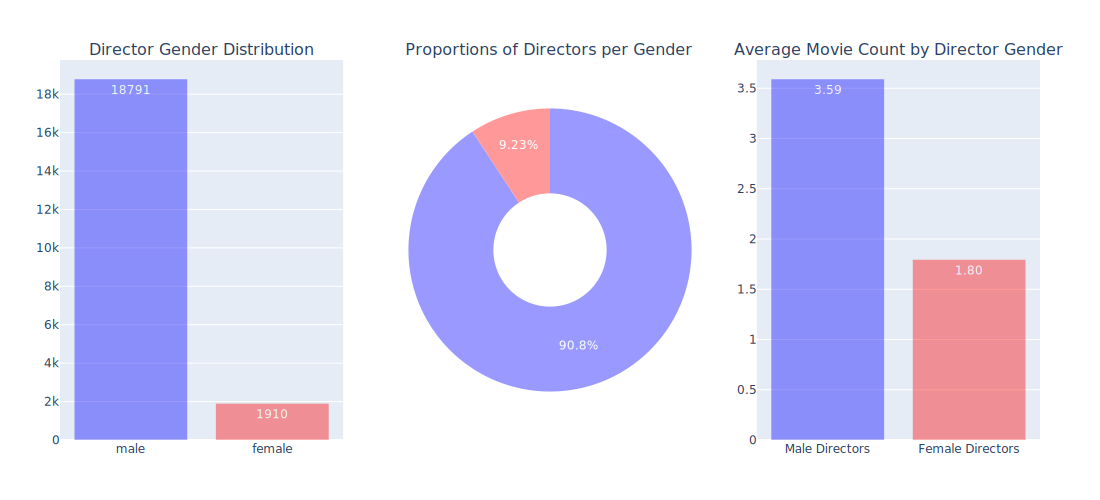

In [ ]:
gender_distribution = crew_merged_unique['gender_directors'].value_counts()
gender_proportions = gender_distribution / gender_distribution.sum()

avg_movie_counts = {
    "Male Directors": men_avg,  
    "Female Directors": women_avg  
}

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=("Director Gender Distribution", "Proportions of Directors per Gender", "Average Movie Count by Director Gender"),
    specs=[[{"type": "bar"}, {"type": "pie"}, {"type": "bar"}]]  
)

fig.add_trace(
    go.Bar(
        x=gender_distribution.index,
        y=gender_distribution.values,
        text=[f"{val}" for val in gender_distribution.values],
        textposition="auto",
        marker_color=["blue", "red"],  
        opacity=0.4 
    ),
    row=1, col=1
)

fig.add_trace(
    go.Pie(
        labels=gender_proportions.index,
        values=gender_proportions.values,
        hole=0.4,
        marker=dict(colors=["blue", "red"]),  # Corrected colors
        opacity=0.4
    ),
    row=1, col=2
)

fig.add_trace(
    go.Bar(
        x=list(avg_movie_counts.keys()),
        y=list(avg_movie_counts.values()),
        text=[f"{val:.2f}" for val in avg_movie_counts.values()],
        textposition="auto",
        marker=dict(color=["blue", "red"]), 
        opacity=0.4
    ),
    row=1, col=3
)

fig.update_layout(
    title_font_size=16,
    showlegend=False,
    height=500,
    width=1100,  
    margin=dict(t=60, b=60, l=60, r=60),
    bargap=0.2  
)

# fig.write_html("director_gender_combined_plots_side_by_side.html")
fig.show("svg")


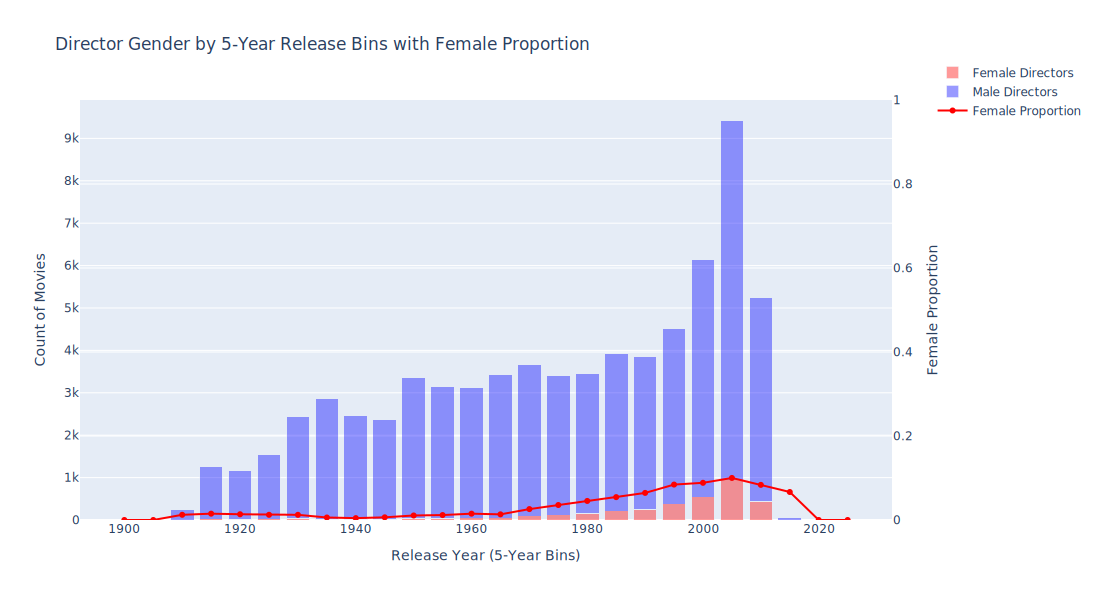

In [ ]:

crew_merged['release_year_bin'] = (crew_merged['Movie_release_date'] // 5) * 5

gender_counts = crew_merged.groupby(['release_year_bin', 'gender_directors']).size().unstack(fill_value=0)
gender_counts['total'] = gender_counts.sum(axis=1)

gender_counts['female_proportion'] = gender_counts['female'] / gender_counts['total']

bar_trace_female = go.Bar(
    x=gender_counts.index,
    y=gender_counts['female'],
    name='Female Directors',
    marker=dict(color='red'),
    opacity=0.4
)

bar_trace_male = go.Bar(
    x=gender_counts.index,
    y=gender_counts['male'],
    name='Male Directors',
    marker=dict(color='blue'),
    opacity=0.4
)

line_trace = go.Scatter(
    x=gender_counts.index,
    y=gender_counts['female_proportion'],
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2'
)

layout = go.Layout(
    title='Director Gender by 5-Year Release Bins with Female Proportion',
    xaxis=dict(title='Release Year (5-Year Bins)'),
    yaxis=dict(title='Count of Movies'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, 1]
    ),
    barmode='stack', 
        legend=dict(
        x=1.05, 
        y=1.1,   
        traceorder='normal',
        orientation='v',
        xanchor='left',   
        yanchor='top',    
    ),
    width=1100,
    height=600
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

# fig.write_html("director_gender_by_year_bins.html")

fig.show("svg")


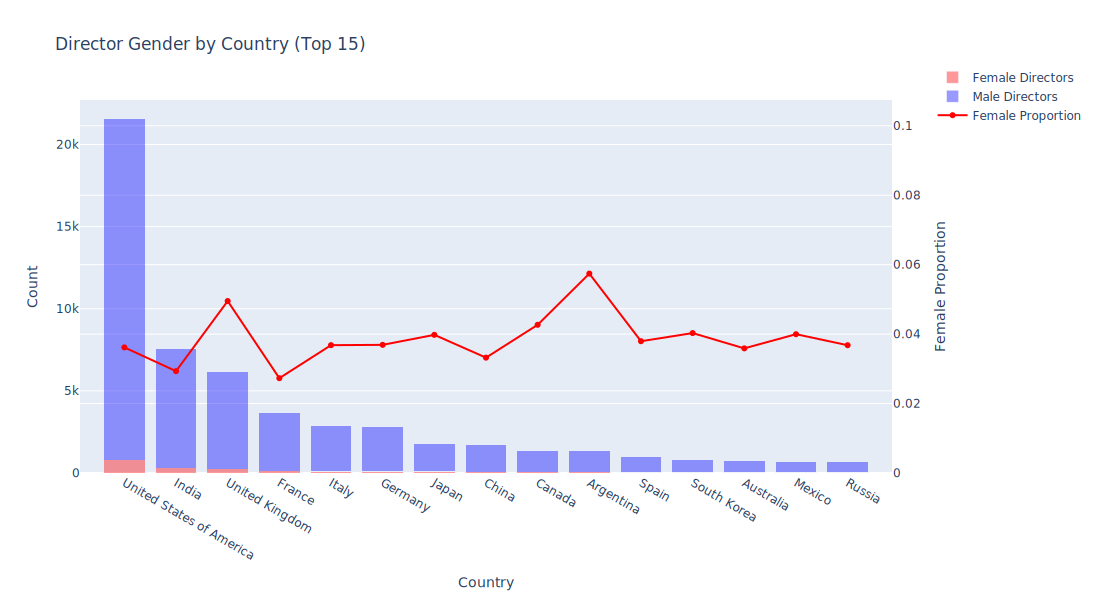

In [ ]:
df_exploded = crew_merged.explode('Movie_countries')
df_exploded = df_exploded.reset_index(drop=True)

country_gender_counts = df_exploded.groupby(['Movie_countries', 'gender_directors']).size().reset_index(name='count')

top_15_countries = country_gender_counts.groupby('Movie_countries')['count'].sum().nlargest(15).index

top_15_data = country_gender_counts[country_gender_counts['Movie_countries'].isin(top_15_countries)]

top_15_data_pivot = top_15_data.pivot_table(index='Movie_countries', columns='gender_directors', values='count', aggfunc='sum', fill_value=0)

top_15_data_pivot['total'] = top_15_data_pivot.sum(axis=1)

female_counts = top_15_data_pivot['female']
female_proportion = female_counts / top_15_data_pivot['total']

top_15_data_pivot = top_15_data_pivot.sort_values(by='total', ascending=False)

bar_trace_female = go.Bar(
    x=top_15_data_pivot.index,
    y=top_15_data_pivot['female'],
    name='Female Directors',
    marker=dict(color='red'),
    opacity=0.4
)

bar_trace_male = go.Bar(
    x=top_15_data_pivot.index,
    y=top_15_data_pivot['male'],
    name='Male Directors',
    marker=dict(color='blue'),
    opacity=0.4
)

line_trace = go.Scatter(
    x=top_15_data_pivot.index,
    y=female_proportion.values,
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2'
)

max_proportion = female_proportion.max()

layout = go.Layout(
    title='Director Gender by Country (Top 15)',
    xaxis=dict(title='Country'),
    yaxis=dict(title='Count'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, max_proportion + 0.05]  
    ),
    barmode='stack', 
    legend=dict(
        x=1.05, 
        y=1.1,  
        traceorder='normal',
        orientation='v',
        xanchor='left',  
        yanchor='top',  
    ),
    width=1100,
    height=600
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

# fig.write_html("director_countries.html")
fig.show("svg")


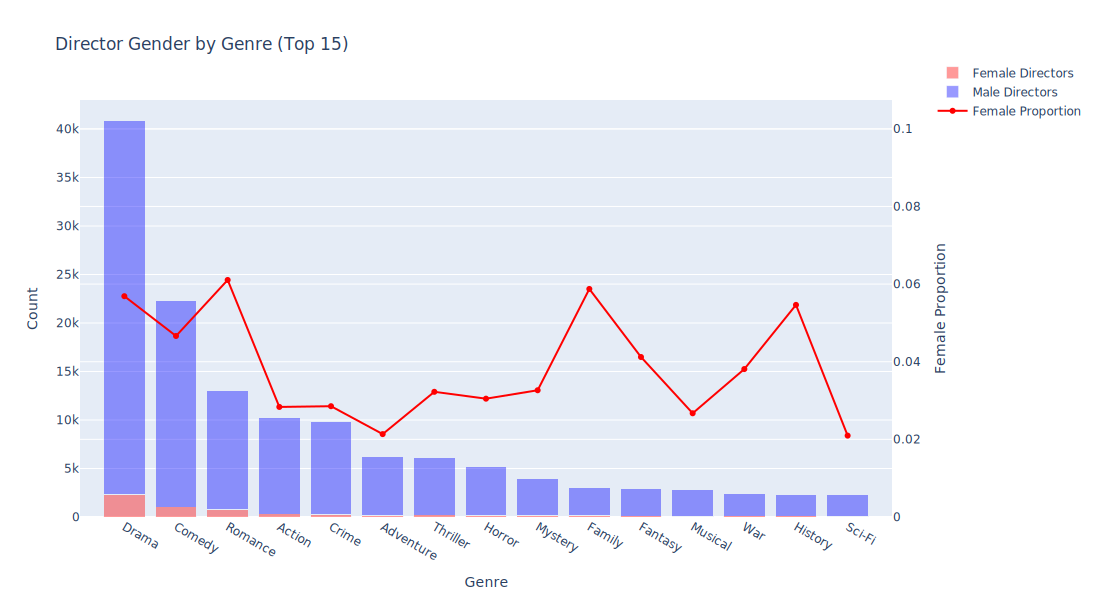

In [ ]:
df_exploded_genres = crew_merged.explode('genres')
df_exploded_genres = df_exploded_genres.reset_index(drop=True)

genre_gender_counts = df_exploded_genres.groupby(['genres', 'gender_directors']).size().reset_index(name='count')

top_15_genres = genre_gender_counts.groupby('genres')['count'].sum().nlargest(15).index

top_15_genre_data = genre_gender_counts[genre_gender_counts['genres'].isin(top_15_genres)]

top_15_genre_data_pivot = top_15_genre_data.pivot_table(index='genres', columns='gender_directors', values='count', aggfunc='sum', fill_value=0)

top_15_genre_data_pivot['total'] = top_15_genre_data_pivot.sum(axis=1)

top_15_genre_data_pivot = top_15_genre_data_pivot.sort_values(by='total', ascending=False)

top_15_genre_data_pivot['female_proportion'] = top_15_genre_data_pivot['female'] / top_15_genre_data_pivot['total']

bar_trace_female = go.Bar(
    x=top_15_genre_data_pivot.index,
    y=top_15_genre_data_pivot['female'],
    name='Female Directors',
    marker=dict(color='red'),
    opacity=0.4
)

bar_trace_male = go.Bar(
    x=top_15_genre_data_pivot.index,
    y=top_15_genre_data_pivot['male'],
    name='Male Directors',
    marker=dict(color='blue'),
    opacity=0.4
)

line_trace = go.Scatter(
    x=top_15_genre_data_pivot.index,  
    y=top_15_genre_data_pivot['female_proportion'],  
    mode='lines+markers',
    name='Female Proportion',
    line=dict(color='red', width=2),
    yaxis='y2',
)

layout = go.Layout(
    title='Director Gender by Genre (Top 15)',
    xaxis=dict(title='Genre'),
    yaxis=dict(title='Count'),
    yaxis2=dict(
        title='Female Proportion',
        overlaying='y',
        side='right',
        range=[0, max_proportion + 0.05]  # Proportion range
    ),
    barmode='stack',
    legend=dict(
        x=1.05,
        y=1.1,
        traceorder='normal',
        orientation='v',
        xanchor='left',
        yanchor='top'
    ),
    width=1100,
    height=600
)

fig = go.Figure(data=[bar_trace_female, bar_trace_male, line_trace], layout=layout)

fig.show("svg")

# fig.write_html("director_gender_by_genre.html")


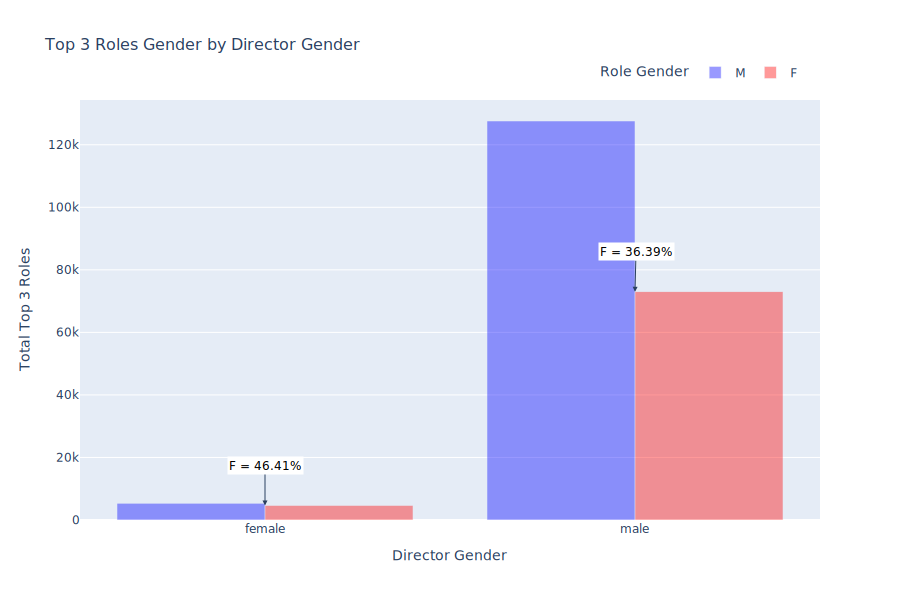

In [ ]:
gender_role_counts = crew_merged.groupby('gender_directors')[['F', 'M']].sum().reset_index()
gender_role_counts_melted = gender_role_counts.melt(id_vars='gender_directors', value_vars=['M', 'F'], 
                                                    var_name='role_gender', value_name='count')

total_female_roles = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'female', 'F'].values[0]
total_male_roles = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'female', 'M'].values[0]
total_roles_by_female_directors = total_female_roles + total_male_roles
female_first_role_proportion = total_female_roles / total_roles_by_female_directors

total_female_roles_male_directors = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'male', 'F'].values[0]
total_male_roles_male_directors = gender_role_counts.loc[gender_role_counts['gender_directors'] == 'male', 'M'].values[0]
total_roles_by_male_directors = total_female_roles_male_directors + total_male_roles_male_directors
female_first_role_proportion_male_directors = total_female_roles_male_directors / total_roles_by_male_directors

fig = px.bar(gender_role_counts_melted, 
             x='gender_directors', 
             y='count', 
             color='role_gender', 
             color_discrete_map={'M': 'blue', 'F': 'red'},  
             barmode='group',
             title='Top 3 Roles Gender by Director Gender',
             labels={'gender_directors': 'Director Gender', 'count': 'Total Top 3 Roles'}
            )

fig.add_annotation(
    x=0, y=total_female_roles,
    text=f"F = {female_first_role_proportion:.2%}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    font=dict(size=12, color="black"),
    bgcolor="white"
)

fig.add_annotation(
    x=1, y=total_female_roles_male_directors,
    text=f"F = {female_first_role_proportion_male_directors:.2%}",
    showarrow=True,
    arrowhead=2,
    ax=1,
    ay=-40,
    font=dict(size=12, color="black"),
    bgcolor="white"
)

fig.update_layout(
    title_font_size=16,
    xaxis_title="Director Gender",
    yaxis_title="Total Top 3 Roles",
    xaxis=dict(title_font_size=14),
    yaxis=dict(title_font_size=14),
    legend_title='Role Gender',
    legend=dict(x=0.7, y=1.1, traceorder='normal', orientation='h', xanchor='left', yanchor='top'),
    width = 900,
    height = 600
)

fig.update_traces(opacity=0.4)

fig.show("svg")

# fig.write_html("director_gender_roles_with_precise_ratios.html")



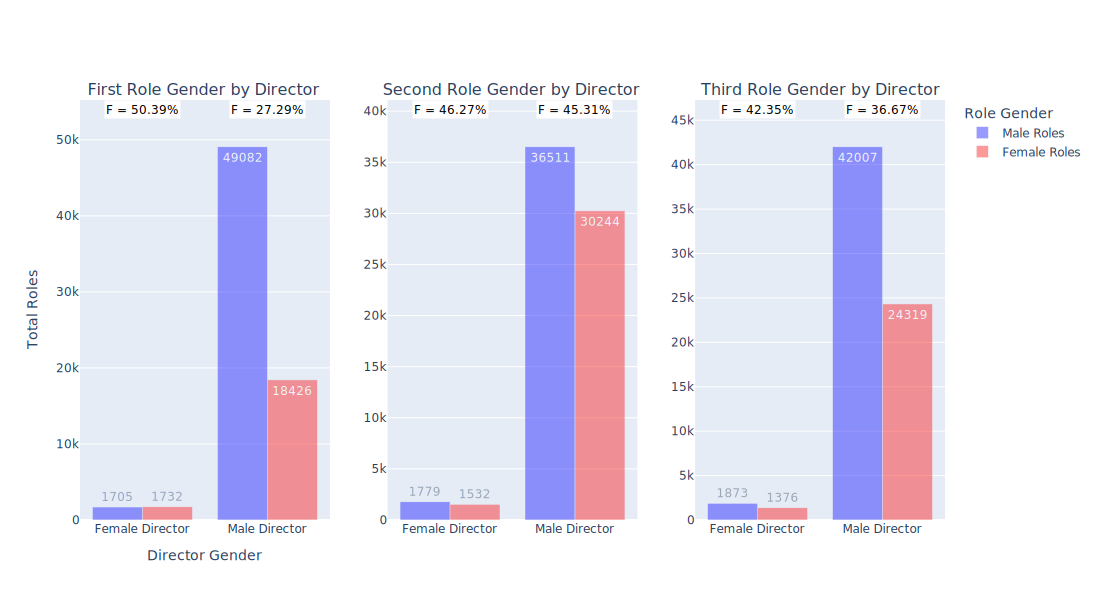

In [ ]:
role_columns = ['first_role_gender', 'second_role_gender', 'third_role_gender']

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f'{role.replace("_", " ").title()} by Director' for role in role_columns]
)

for i, role in enumerate(role_columns):
    role_counts = crew_merged.groupby('gender_directors')[role].value_counts().unstack(fill_value=0).reset_index()

    role_counts['gender_directors'] = role_counts['gender_directors'].map({'male': 'Male Director', 'female': 'Female Director'})

    # Add Male Roles first, then Female Roles (swapped order)
    fig.add_trace(go.Bar(
        x=role_counts['gender_directors'],
        y=role_counts['M'],
        name='Male Roles',
        marker=dict(color='blue'), 
        text=role_counts['M'],
        textposition='auto',
        showlegend=(i == 0),  
        opacity=0.4 
    ), row=1, col=i+1)

    fig.add_trace(go.Bar(
        x=role_counts['gender_directors'],
        y=role_counts['F'],
        name='Female Roles',
        marker=dict(color='red'), 
        text=role_counts['F'],
        textposition='auto',
        showlegend=(i == 0),  
        opacity=0.4 
    ), row=1, col=i+1)

    max_y = role_counts[['F', 'M']].max().max()  

    for j, row in role_counts.iterrows():
        total_roles = row['F'] + row['M']
        if total_roles > 0:
            female_ratio = row['F'] / total_roles
            proportion_text = f"F = {female_ratio:.2%}" 

            fig.add_annotation(
                x=row['gender_directors'],
                y=max_y + 0.1 * max_y, 
                text=proportion_text,
                showarrow=False,
                font=dict(size=12, color="black"),
                bgcolor="white",
                row=1, col=i+1
            )

fig.update_layout(
    barmode='group',  
    xaxis_title="Director Gender",
    yaxis_title="Total Roles",
    title_font_size=16,
    xaxis=dict(title_font_size=14),
    yaxis=dict(title_font_size=14),
    height=600,
    width=1100,
    showlegend=True,
    legend_title="Role Gender",
    xaxis_tickangle=0
)

for i in range(1, 4):
    fig.update_xaxes(tickmode='array', tickvals=['Female Director', 'Male Director'], 
                     ticktext=['Female\nDirector', 'Male\nDirector'], row=1, col=i)

fig.show("svg")

# fig.write_html("director_role_distribution_with_ratios.html")


Let's look at revenues

In [ ]:
crew_merged_revenue = crew_merged.dropna(subset=["Movie_box_office_revenue"])

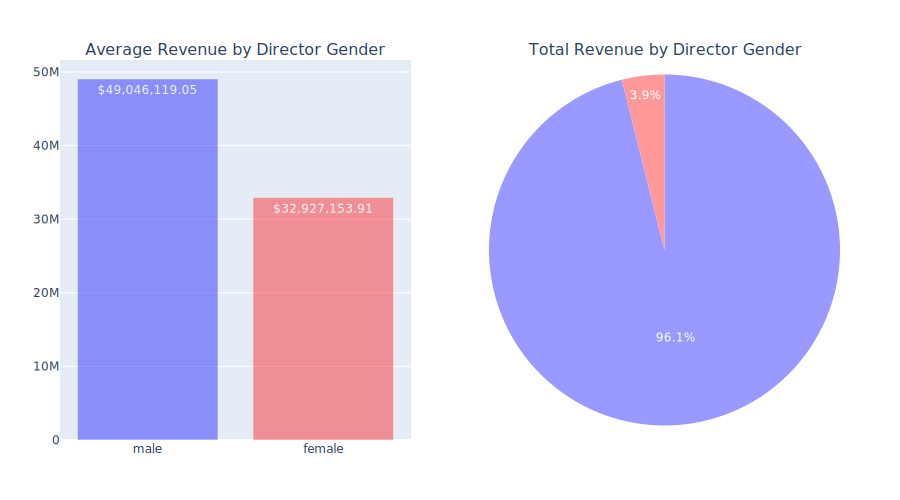

In [ ]:
average_revenue_by_gender = crew_merged_revenue.groupby('gender_directors')['Movie_box_office_revenue'].mean()

total_revenue_by_gender = crew_merged_revenue.groupby('gender_directors')['Movie_box_office_revenue'].sum()

average_revenue_by_gender = average_revenue_by_gender[['male', 'female']]
total_revenue_by_gender = total_revenue_by_gender[['male', 'female']]

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Average Revenue by Director Gender", "Total Revenue by Director Gender"),
    specs=[[{"type": "bar"}, {"type": "pie"}]]  
)

# First subplot: Average Revenue by Director Gender 
fig.add_trace(
    go.Bar(
        x=average_revenue_by_gender.index,
        y=average_revenue_by_gender.values,
        text=[f"${val:,.2f}" for val in average_revenue_by_gender.values],
        textposition="auto",
        marker_color=["blue", "red"],  
        opacity=0.4  
    ),
    row=1, col=1
)

# Second subplot: Total Revenue by Director Gender 
fig.add_trace(
    go.Pie(
        labels=total_revenue_by_gender.index,
        values=total_revenue_by_gender.values,
        marker=dict(colors=["blue", "red"]),  
        opacity=0.4  
    ),
    row=1, col=2
)

fig.update_layout(
    title_font_size=16,
    showlegend=False,
    height=500,
    width=900,  
    margin=dict(t=60, b=60, l=60, r=60),
    bargap=0.2  
)

# fig.write_html("revenue_by_gender.html")
fig.show("svg")
